In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import sympy as sp
from matplotlib import ticker
import os

import functions as fnc

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 17}


# 0) Umrechnen

In [2]:
def Etot_conversion(p):
    """takes p in MeV/c"""
    m0 = 0.51099895000 # MeV/c^2
    c = 299792458
    
    Etot = np.sqrt(p**2-m0**2)
    
    return Etot

def p_conversion(Etot):
    """Rechnet tot Energie in Impuls um"""
    m0 = 0.51099895000 # MeV/c
    c = 299792458
    
    p = np.sqrt(Etot**2-m0**2) 
    
    return p

def EKin_conversion(p):
    """Rechnet Impuls in kinetische Energie um"""
    m0 = 0.51099895000 # MeV/c
    c = 299792458
    
    Ekin = m0 * (np.sqrt(1 + (p/(m0))**2) - 1)
    
    return Ekin


# 1) Measurement and Fit

In [3]:
def importsGemessen(data):
    """
    Nur für gemessene Daten. 
    Nimmt Daten und gibt I, B U in A, mT, V aus
    """
    data = np.genfromtxt(f"{data}", skip_header = 2, skip_footer=1, delimiter="	")
    data = np.transpose(data)
    I = data[0] #A
    B = data[1] #mT 
    U = data[2] #V 
    return [I, B, U]


def ParamterFitB(dataGemessen, Messdatenausgabe = False, Pos = 1, Windungen = 250, Stoff = "SteelIronStell", CST = True, Fit = False, AllInOne = False, Plot = True, Text = True, Datenausgabe = True, **kwargs):
    """
    dataGemessen = Gemessene Daten. Als "Messung1.dat" reingeben
    dataSimulation = von CST errechnete Daten. Als "MessungPos1Steel1008.dat" reingeben
    Pos = 1, 2, 3, 4 Position im Magneten 
    Windungen = 250 errechnete Windungszahl
    Stoff = "Steel1008" nur für Legende 
    CST = True, falls True werden simulierte Daten mit in den Plot gegeben (nur falls Plot = True)
    Fit = False, falls True wird die Regressionsgerade mit in den Plot gegeben  (nur falls Plot = True)
    AllInOne = False, falls True werden alle Daten in einem Plot geplottet (falls mehrere Male diese Funtion in einer Zelle aufgerufen wird) (nur falls Plot = True)
    Plot = True, falls True wird geplottet
    Text = True, falls True wird Text (Für den Hinweg: a0 = 0.5374802725263685 +- 0.012169832930567406, ...) mit ausgegeben 
    Datenausgabe = True, falls True wird R, Fitparameter ([[[a0h, ua0h], [a1h, ua1h], ...], [[a0r, ua0r], [a1r, ua1r], ...]]) mit ausgegeben 
    Messdatenausgabe = False, falls True werden die Daten vom gemessenen plus ihre Unsicherheiten ausgegegeben 
    """
    
#----------------------------------------------    
    #          LADEN DER WERTE 

    dataGemessen = np.transpose(np.genfromtxt(f"{dataGemessen}", skip_header = 2, skip_footer = 1))
    
    if 'dataSimulation' in kwargs:
        dataSimulation = np.transpose(np.genfromtxt(kwargs["dataSimulation"], skip_header = 2, skip_footer = 2))
        
    if 'Messung2' in kwargs:
        dataGemessen2 = np.transpose(np.genfromtxt(kwargs["Messung2"], skip_header = 2, skip_footer = 1))

    #----------------------------------------------    
    #          FEHLER DER WERTE
    # nachzulesen in meiner Datei, wie ich darauf kam
    
    # Systematischer Fehler

    if Pos == 4: 
        k_sys = -0.1 #mT

    else:
        k_sys = -1.0 #mT
    
    #Ablesefehle
    if Pos == 4: #nur bei der vierten Messung anders gewesen
        u_Ab = np.sqrt(0.005**2)
    else: 
        u_Ab = np.sqrt(0.05**2) # plus linearitätsfehler von 0.1% pro Messbereich

    #Gerätefehler der einzelnen Messgeräte - MÜSSEN NOCH ERGÄNZT WERDEN MIT ECHTEN WERTEN 
    u_GA = 0* 0.002 * dataGemessen[0] # jetzt 0 erstmal #Sage 2% vom Wert, idk tho
    # gerätefehler ohne sonde
    u_GHHall = 0.002 * (dataGemessen[1] - k_sys)  #1%+-2digit
    u_GV = 0* 0.002 * dataGemessen[2]

    #digit error
    unc_HHall = []
    BWerte = np.array(dataGemessen[1] - k_sys)
    for i in range(len(BWerte)):
        #for a number n this gives the 2 digit error
        unc_HHall.append(2*10**(-(len(repr(BWerte[i]))-2)))
    
    u_GHHall = np.array(u_GHHall) + np.array(unc_HHall)
    
    u_GHSonde = 0.0005 * (dataGemessen[1] - k_sys)
    
    Messbereich = 200 #mT
    u_Linearität = 0 * 0.5 / 100 * Messbereich #0.5%  WAS IST MIT DEM PLUS MINUS 0,1% vom Messbereich?
    
    
    u_GH = np.sqrt(u_GHHall**2+u_GHSonde**2+u_Linearität**2)
    
    
    #Pytagoräische Addition der Fehler
    uI = np.sqrt(u_Ab**2 + u_GA**2) 
    uB = np.sqrt(u_Ab**2 + u_GH**2) 
    uU = np.sqrt(u_Ab**2 + u_GV**2)

    if 'Messung2' in kwargs:    
        #Gerätefehler der einzelnen Messgeräte
        u_GA2 = 0* 0.002 * dataGemessen2[0] #insignificant
        u_GH2 = 0.001 * (dataGemessen2[1] - k_sys) #1%+-2digit
        u_GV2 = 0* 0.002 * dataGemessen2[2] #insignificant
        
        #Pytagoräische Addition der Fehler
        uI2 = np.sqrt(u_Ab**2 + u_GA2**2) 
        uB2 = np.sqrt(u_Ab**2 + u_GH2**2) 
        uU2 = np.sqrt(u_Ab**2 + u_GV2**2)

#----------------------------------------------    
    #          SORTIEREN DER WERTE        
        
    index = np.where(dataGemessen[1] == min(dataGemessen[1]))[0][0]   # gehe immer bis zum einschließlich maximalen Wert hoch, dann von dort aus wieder runter
    
    # Nehme den ersten Messwert raus, weil der bei keiner Spannung kam    
    I = dataGemessen[0] 
    uI = uI

    for i in range(len(I)):
        if I[i] == 0:
            I[i] = 10**(-20)
    
    B = dataGemessen[1] - k_sys #Ziehe systematischen Fehler ab
    uB = uB 
    
    U = dataGemessen[2]
    uU = uU
   
    if 'dataSimulation' in kwargs:
        ISim = dataSimulation[1] / Windungen #A
        BSim = dataSimulation[Pos + 2] * 1000 #mT
        
    if 'Messung2' in kwargs: 
        
        index2 = np.where(dataGemessen2[1] == min(dataGemessen2[1]))[0][0]   # gehe immer bis zum einschließlich maximalen Wert hoch, dann von dort aus wieder runter

        # Nehme den ersten Messwert raus, weil der bei keiner Spannung kam    
        I2 = dataGemessen2[0]
        uI2 = uI2
        
        for i in range(len(I2)):
            if I2[i] == 0:
                I2[i] = 10**(-20)

        
        B2 = dataGemessen2[1] - k_sys #Ziehe systematischen Fehler ab
        uB2 = uB2

        U2 = dataGemessen2[2]
        uU2 = uU2
        
#----------------------------------------------
    #          FITTEN DER WERTE
    
    def reg(B, a0, a1, a2, a3):
        return a0 +  a1 * B +  a2 * B**2 +  a3 * B**3


    x = I[:index+1]
    y = B[:index+1]
    uy = uB[:index+1]
    popt, pcov = scipy.optimize.curve_fit(reg, x, y, sigma = uy) 
    a0h, a1h, a2h, a3h = popt
    ua0h, ua1h, ua2h, ua3h = np.sqrt(np.diag(pcov))
    residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
    r_squaredh = 1 - (ss_res / ss_tot)
    
    n = len(y)
    p = 4
    chi2h = 1 / (n-p) * sum((reg(x, *popt) - y)**2 / uy**2 )
    
    plt.rcParams['figure.figsize'] = (11, 2)
    plt.rc('font', **font)
    
    if Plot == True:
        plt.errorbar(x, residuals, uy, fmt = ".",  capsize=2, markersize = 8, zorder=3, label = "Increasing Current")
        plt.axhline(y = 0, color = 'black', linestyle = '-')
        plt.grid()


    
    if Text == True:
        print(f"Increasing current: \n R^2 = {r_squaredh} \n a0 = {a0h} +- {ua0h} mT,\n a1 = {a1h} +- {ua1h} mT/A, \n a2 = {a2h} +- {ua2h} mT/A^2,\n a3 = {a3h} +- {ua3h} mT/A^3")

    x = I[index:]
    y = B[index:]
    uy = uB[index:]
    popt, pcov = scipy.optimize.curve_fit(reg, x, y, sigma = uy) 
    a0r, a1r, a2r, a3r= popt
    ua0r, ua1r, ua2r, ua3r = np.sqrt(np.diag(pcov))
    residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
    r_squaredr = 1 - (ss_res / ss_tot)
    
    
    n = len(y)
    p = 4
    chi2r = 1 / (n-p) * sum((reg(x, *popt) - y)**2 / uy**2 )
    
    if Plot == True:
        plt.errorbar(x, residuals, uy, fmt = ".",  capsize=2, markersize = 8, zorder=3, label = "Decreasing Current")


    if Text == True:
        print(f"Decreasing current: \n R^2 = {r_squaredr} \n a0 = {a0r} +- {ua0r} mT,\n a1 = {a1r} +- {ua1r} mT/A, \n a2 = {a2r} +- {ua2r} mT/A^2,\n a3 = {a3r} +- {ua3r} mT/A^3")
    
    
    if 'Messung2' in kwargs:
        x = I2[:index2+1]
        y = B2[:index2+1]
        uy = uB2[:index2+1]
        popt, pcov = scipy.optimize.curve_fit(reg, x, y , sigma = uy) 
        a0h2, a1h2, a2h2, a3h2 = popt
        ua0h2, ua1h2, ua2h2, ua3h2 = np.sqrt(np.diag(pcov))
        residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
        r_squaredh2 = 1 - (ss_res / ss_tot)

        if Plot == True:
            plt.errorbar(x, residuals, uy, fmt = ".",  capsize=2, markersize = 8, zorder=3, label = "Decreasing Current")


        if Text == True:
            print(f"Increasing current: \n R^2 = {r_squaredh2} \n a02 = {a0h2} +- {ua0h2},\n a12 = {a1h2} +- {ua1h2}, \n a22 = {a2h2} +- {ua2h2},\n a32 = {a3h2} +- {ua3h2}")

        x = I2[index2:]
        y = B2[index2:]
        uy = uB2[index2:]
        popt, pcov = scipy.optimize.curve_fit(reg, x, y, sigma = uy) 
        a0r2, a1r2, a2r2, a3r2= popt
        ua0r2, ua1r2, ua2r2, ua3r2 = np.sqrt(np.diag(pcov))
        residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
        r_squaredr2 = 1 - (ss_res / ss_tot)

        if Text == True:
            print(f"Decreasing current: \n R^2 = {r_squaredr2} \n a02 = {a0r2} +- {ua0r2},\n a12 = {a1r2} +- {ua1r2}, \n a22 = {a2r2} +- {ua2r2},\n a32 = {a3r2} +- {ua3r2}")

    
    if 'dataSimulation' in kwargs:

        x = ISim
        y = BSim
        popt, pcov = scipy.optimize.curve_fit(reg, x, y) 
        a0S, a1S, a2S, a3S= popt
        ua0S, ua1S, ua2S, ua3S = np.sqrt(np.diag(pcov))
        residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
        r_squareds = 1 - (ss_res / ss_tot)
    

        if Text == True:
            print(f"Simulation: \n R^2 = {r_squareds} \n a0 = {a0r} +- {ua0r},\n a1 = {a1r} +- {ua1r}, \n a2 = {a2r} +- {ua2r},\n a3 = {a3r} +- {ua3r}")

    x = np.linspace(0, 22, 1000) # für Fit
    
    if Plot == True: 
        plt.xlabel("I in A")
        plt.ylabel("Residuals in mT")

        plt.title(f"Position {Pos}, Residuals for the in- and decreasing current")
        plt.legend(loc = (1.015,0), title = f"$\chi^2$ increasing = {chi2h:.4}\n $\chi^2$ decreasing = {chi2r:.4}")
        plt.savefig(f"BOfIResiduen{Pos}.svg", format='svg', dpi=1000, bbox_inches='tight')

        plt.show()
        plt.rcParams['figure.figsize'] = (11, 7)

    
#----------------------------------------------
    #          KLEINE RECHNUNGEN    
    
    
    R = np.mean(U[1:-1] / I[1:-1])
    u_R =max(np.sqrt((uU[1:-1] / I[1:-1])**2 + (- U[1:-1] / I[1:-1]**2 * uI[1:-1])**2)) #rechne maximale Unsicherheit von R aus

    if 'Messung2' in kwargs:
        R2 = np.mean(U2[1:-1] / I2[1:-1])
        u_R2 =max(np.sqrt((uU2[1:-1] / I2[1:-1])**2 + (- U2[1:-1] / I2[1:-1]**2 * uI2[1:-1])**2)) #rechne maximale Unsicherheit von R aus


#----------------------------------------------
    #          PLOTTEN DER WERTE
    

    plt.rc('font', **font)
    if Plot == True:
        
        plt.errorbar(I[:index+1], B[:index+1], uB[:index+1], uI[:index+1], ".", markersize = 6, capsize=4, label = "Increasing  current")
        plt.errorbar(I[index:], B[index:], uB[index:], uI[index:], ".", markersize = 6, capsize=4, label = "Decreasing current")
        
        if 'dataSimulation' in kwargs:
            if CST == True:
                plt.plot(ISim, BSim, "+", label = f"Simulation, Material: {Stoff}", color = "black")
        
        if 'Messung2' in kwargs:
            plt.errorbar(I2[:index2+1], B2[:index2+1], uB2[:index2+1], uI2[:index2+1], "+", markersize = 8, label = "Measurement 2, Increasing  current")
            plt.errorbar(I2[index2:], B2[index2:], uB2[index2:], uI2[index2:], "+", markersize = 8, label = "Measurement 2, Decreasing current")
       
        
        if Fit == True:
            plt.plot(x, reg(x, a0h, a1h, a2h, a3h), linestyle='-', linewidth=0.5, label = "Increasing current")
            plt.plot(x, reg(x, a0r, a1r, a2r, a3r), linestyle='-', linewidth=0.5, label = "Decreasing current")
            if 'Messung2' in kwargs:
                plt.plot(x, reg(x, a0h2, a1h2, a2h2, a3h2), linestyle='-', linewidth=0.5, label = "Measurement 2, Increasing current")
                plt.plot(x, reg(x, a0r2, a1r2, a2r2, a3r2), linestyle='-', linewidth=0.5, label = "Measurement 2,Decreasing current")
           

        plt.xlabel("I in A")
        plt.ylabel("B in mT")

        plt.rcParams['figure.figsize'] = (11, 7)
        plt.title(f"Position {Pos}, B vs I for the in- and decreasing current")
        
        print(fnc.roundingDIN(a1h, ua1h))
        
        if 'dataSimulation' in kwargs:
            if 'Messung2' in kwargs:
                plt.legend(loc = (0.03, 0.005), title = f"$f(x) = a_0 + a_1 \; x + a_2 \; x^2 + a_3 \; x^3$ \n $R =$ ({fnc.roundingDIN(R, u_R)[0]} +- {fnc.roundingDIN(R, u_R)[1]})  $\Omega$ \n Increasing current: \n $R^2$ = {r_squaredh:.4f} \n $a_0$ = ({fnc.roundingDIN(a0h, ua0h)[0]} +- {fnc.roundingDIN(a0h, ua0h)[1]}) mT, \n $a_1$ = ({fnc.roundingDIN(a1h, ua1h)[0]} +- {fnc.roundingDIN(a1h, ua1h)[1]}) mT/ A \n Decreasing current: \n $R^2$ = {r_squaredr:.4f} \n $a_0$ = ({fnc.roundingDIN(a0r, ua0r)[0]} +- {fnc.roundingDIN(a0r, ua0r)[1]}) mT, \n $a_1$ = ({fnc.roundingDIN(a1r, ua1r)[0]} +- {fnc.roundingDIN(a1r, ua1r)[1]}) mT/ A \n Measurement 2 \n $R_2 =$ ({R2:.4f} +- {u_R2:.4f})  Ohm \n Increasing current: \n $R^2$ = {r_squaredh:.4f}\n $a_2 0$ = ({a0h2:.4f} +- {ua0h2:.4f}) mT, \n $a_2 1$ = ({a1h2:.4f} +- {ua1h2:.4f}) mT/ A \n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_2 0$ = ({a0r2:.4f} +- {ua0r2:.4f}) mT, \n $a_2 1$ = ({a1r2:.4f} +- {ua1r2:.4f}) mT/ A \n Simulation \n $R^2$ = {r_squareds:.4f}\n $a_0$ = ({a0S:.4f} +- {ua0S:.4f}) mT, \n $a_1$ = ({a1S:.4f} +- {ua1S:.4f}) mT/ A", bbox_to_anchor=(1, 0., 0.5, 1))
            else:
                plt.legend(loc = (0.03, 0.005), title = f"$f(x) = a_0 + a_1 \; x + a_2 \; x^2 + a_3 \; x^3$ \n $R =$ ({fnc.roundingDIN(R, u_R)[0]} +- {fnc.roundingDIN(R, u_R)[1]})  $\Omega$  \n Increasing current: \n $R^2$ = {r_squaredh:.4f} \n $a_0$ = ({fnc.roundingDIN(a0h, ua0h)[0]} +- {fnc.roundingDIN(a0h, ua0h)[1]}) mT, \n $a_1$ = ({fnc.roundingDIN(a1h, ua1h)[0]} +- {fnc.roundingDIN(a1h, ua1h)[1]}) mT/ A \n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_0$ = ({fnc.roundingDIN(a0r, ua0r)[0]} +- {fnc.roundingDIN(a0r, ua0r)[1]}) mT, \n $a_1$ = ({fnc.roundingDIN(a1r, ua1r)[0]} +- {fnc.roundingDIN(a1r, ua1r)[1]}) mT/ A \n Simulation: \n $R^2$ = {r_squareds:.4f} \n $a_0$ = ({a0S:.4f} +- {ua0S:.4f}) mT, \n $a_1$ = ({a1S:.4f} +- {ua1S:.4f}) mT /A", bbox_to_anchor=(1, 0., 0.5, 1))
        else:
            if 'Messung2' in kwargs:
                plt.legend(loc = (0.03, 0.005), title = f"$f(x) = a_0 + a_1 \; x + a_2 \; x^2 + a_3 \; x^3$ \n $R =$ ({fnc.roundingDIN(R, u_R)[0]} +- {fnc.roundingDIN(R, u_R)[1]})  $\Omega$  \n Increasing current: \n $R^2$ = {r_squaredh:.4f} \n $a_0$ = ({fnc.roundingDIN(a0h, ua0h)[0]} +- {fnc.roundingDIN(a0h, ua0h)[1]}) mT, \n $a_1$ = ({fnc.roundingDIN(a1h, ua1h)[0]} +- {fnc.roundingDIN(a1h, ua1h)[1]}) mT/ A \n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_0$ = ({fnc.roundingDIN(a0r, ua0r)[0]} +- {fnc.roundingDIN(a0r, ua0r)[1]}) mT, \n $a_1$ = ({fnc.roundingDIN(a1r, ua1r)[0]} +- {fnc.roundingDIN(a1r, ua1r)[1]}) mT/ A \n Measurement 2 \n $R_2 =$ ({R2:.4f} +- {u_R2:.4f})  Ohm \n Increasing current: \n $R^2$ = {r_squaredh:.4f}\n $a_2 0$ = ({a0h2:.4f} +- {ua0h2:.4f}) mT, \n $a_2 1$ = ({a1h2:.4f} +- {ua1h2:.4f}) mT/ A \n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_2 0$ = ({a0r2:.4f} +- {ua0r2:.4f}) mT, \n $a_2 1$ = ({a1r2:.4f} +- {ua1r2:.4f}) mT/ A", bbox_to_anchor=(1, 0., 0.5))
            else:
                plt.legend(loc = (0.03, 0.005), title = f"$f(x) = a_0 + a_1 \; x + a_2 \; x^2 + a_3 \; x^3$ \n $R =$ ({fnc.roundingDIN(R, u_R, returnAsString = True)[0]} +- {fnc.roundingDIN(R, u_R, returnAsString = True)[1]})  $\Omega$  \n Increasing current: \n $R^2$-Test = {r_squaredh:.4f} \n $a_0$ = ({fnc.roundingDIN(a0h, ua0h, returnAsString = True)[0]} +- {fnc.roundingDIN(a0h, ua0h, returnAsString = True)[1]}) mT, \n $a_1$ = ({fnc.roundingDIN(a1h, ua1h, returnAsString = True)[0]} +- {fnc.roundingDIN(a1h, ua1h, returnAsString = True)[1]}) mT/ A \n Decreasing current: \n $R^2$-Test = {r_squaredr:.4f}\n $a_0$ = ({fnc.roundingDIN(a0r, ua0r, returnAsString = True)[0]} +- {fnc.roundingDIN(a0r, ua0r, returnAsString = True)[1]}) mT, \n $a_1$ = ({fnc.roundingDIN(a1r, ua1r, returnAsString = True)[0]} +- {fnc.roundingDIN(a1r, ua1r, returnAsString = True)[1]}) mT/ A", bbox_to_anchor=(1, 0., 0.5, 1),  )
        
        plt.grid()
        plt.savefig(f"BOfI{Pos}.svg", format='svg', dpi=1000, bbox_inches='tight')
        
        if AllInOne == False:
            plt.show()
        
       

        
#----------------------------------------------
    #          AUSGABE DER WERTE
     
    if Messdatenausgabe == True:
        if 'dataSimulation' in kwargs:
            return [[I, uI], [B, uB], [U, uU]], [[[a0h, ua0h], [a1h, ua1h], [a2h, ua2h], [a3h, ua3h]], [[a0r, ua0r], [a1r, ua1r], [a2r, ua2r], [a3r, ua3r]], [[a0S, ua0S], [a1S, ua1S], [a2S, ua2S], [a3S, ua3S]]]
   
    
        else:
            return [[I, uI], [B, uB], [U, uU]], [[[a0h, ua0h], [a1h, ua1h], [a2h, ua2h], [a3h, ua3h]], [[a0r, ua0r], [a1r, ua1r], [a2r, ua2r], [a3r, ua3r]]]
    
        
        
    if Datenausgabe == True:
        
        if 'dataSimulation' in kwargs:
            return R, [[[a0h, ua0h], [a1h, ua1h], [a2h, ua2h], [a3h, ua3h]], [[a0r, ua0r], [a1r, ua1r], [a2r, ua2r], [a3r, ua3r]], [[a0S, ua0S], [a1S, ua1S], [a2S, ua2S], [a3S, ua3S]]]
   
    
        else:
            return R, [[[a0h, ua0h], [a1h, ua1h], [a2h, ua2h], [a3h, ua3h]], [[a0r, ua0r], [a1r, ua1r], [a2r, ua2r], [a3r, ua3r]]]
    
    
    

Increasing current: 
 R^2 = 0.9999925357810615 
 a0 = 0.7427469147316219 +- 0.05964209079811169 mT,
 a1 = -9.006396224117442 +- 0.040297794977685306 mT/A, 
 a2 = 0.0064907348366240415 +- 0.006283342998936754 mT/A^2,
 a3 = -0.000170621952468843 +- 0.0002499843987748412 mT/A^3
Decreasing current: 
 R^2 = 0.9999856494604157 
 a0 = -0.3823407345971139 +- 0.06636667418614528 mT,
 a1 = -9.12818833909458 +- 0.04802417681925548 mT/A, 
 a2 = 0.014837229645710857 +- 0.007344915503620162 mT/A^2,
 a3 = -0.0001954187687230379 +- 0.0002856972386689701 mT/A^3


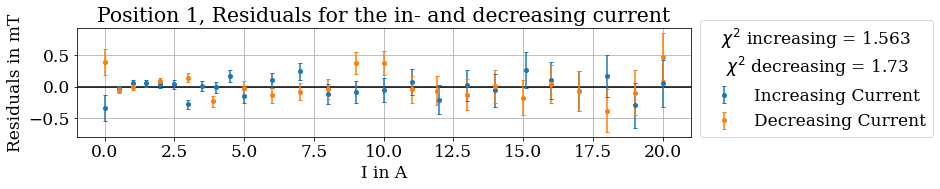

[-9.01, 0.05]


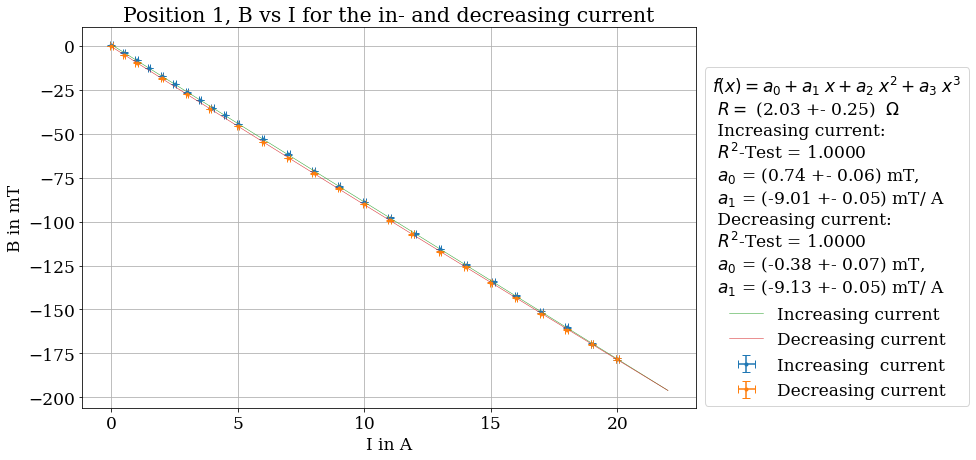

(2.0335657686984456,
 [[[0.7427469147316219, 0.05964209079811169],
   [-9.006396224117442, 0.040297794977685306],
   [0.0064907348366240415, 0.006283342998936754],
   [-0.000170621952468843, 0.0002499843987748412]],
  [[-0.3823407345971139, 0.06636667418614528],
   [-9.12818833909458, 0.04802417681925548],
   [0.014837229645710857, 0.007344915503620162],
   [-0.0001954187687230379, 0.0002856972386689701]]])

In [58]:
ParamterFitB("Messung1.dat", Windungen = 4, Stoff = "Iron", AllInOne = False, Pos = 1, Text = True, Fit = True)


Increasing current: 
 R^2 = 0.9999925357810615 
 a0 = 0.7427469147316219 +- 0.05964209079811169 mT,
 a1 = -9.006396224117442 +- 0.040297794977685306 mT/A, 
 a2 = 0.0064907348366240415 +- 0.006283342998936754 mT/A^2,
 a3 = -0.000170621952468843 +- 0.0002499843987748412 mT/A^3
Decreasing current: 
 R^2 = 0.9999856494604157 
 a0 = -0.3823407345971139 +- 0.06636667418614528 mT,
 a1 = -9.12818833909458 +- 0.04802417681925548 mT/A, 
 a2 = 0.014837229645710857 +- 0.007344915503620162 mT/A^2,
 a3 = -0.0001954187687230379 +- 0.0002856972386689701 mT/A^3


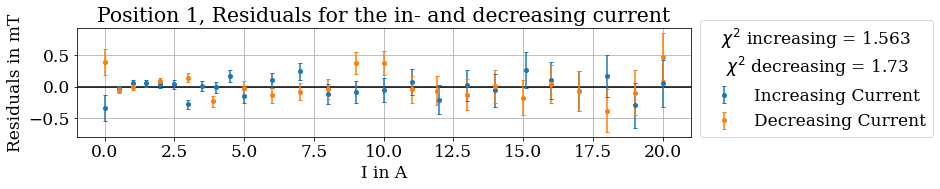

[-9.01, 0.05]


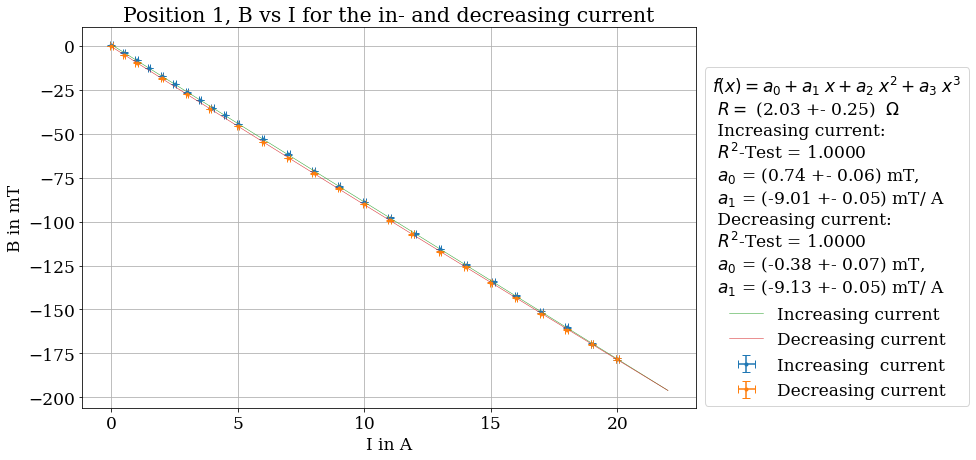


M2
Increasing current: 
 R^2 = 0.9999653224424299 
 a0 = -0.06792104495980208 +- 0.16913829461485544 mT,
 a1 = -8.78513537526791 +- 0.11310103243607017 mT/A, 
 a2 = -0.02047754581717196 +- 0.016676270192503218 mT/A^2,
 a3 = 0.0007775813800269494 +- 0.000636431337460061 mT/A^3
Decreasing current: 
 R^2 = 0.9999832278332347 
 a0 = 0.10234091017926429 +- 0.1467827830724046 mT,
 a1 = -9.248961677413288 +- 0.09524719279267084 mT/A, 
 a2 = 0.02277074832814832 +- 0.014032272372598052 mT/A^2,
 a3 = -0.00033556062801074453 +- 0.0005297493093685152 mT/A^3


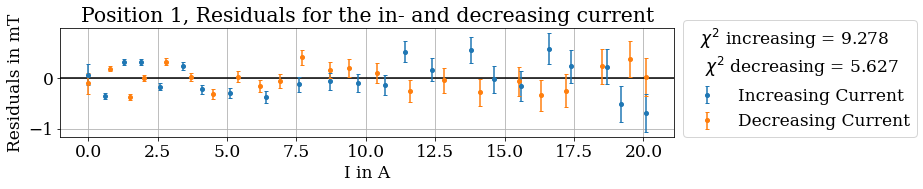

[-8.79, 0.12]


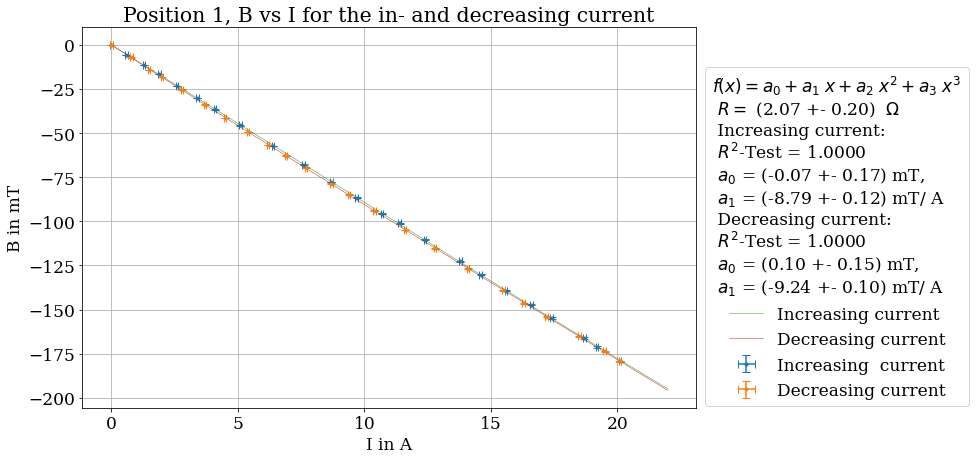

Increasing current: 
 R^2 = 0.9999890892203067 
 a0 = 0.006038698347858775 +- 0.07483464408337717 mT,
 a1 = -8.817797881737699 +- 0.04562709964469959 mT/A, 
 a2 = -0.01818754892580666 +- 0.006504292849930341 mT/A^2,
 a3 = 0.0006759103136386891 +- 0.0002443873937401674 mT/A^3
Decreasing current: 
 R^2 = 0.9999895959079513 
 a0 = 0.18345591834763628 +- 0.0683692028701236 mT,
 a1 = -9.34305907047802 +- 0.049752092755020266 mT/A, 
 a2 = 0.03223317670174383 +- 0.007735152099308825 mT/A^2,
 a3 = -0.0006573502711832792 +- 0.0003040489329281869 mT/A^3


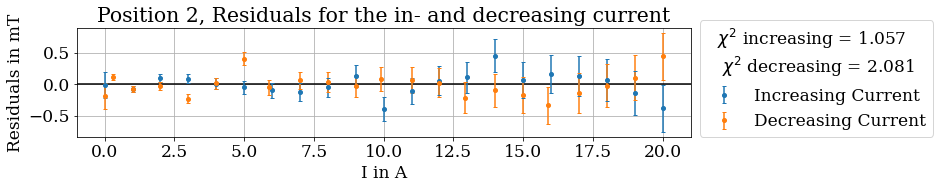

[-8.82, 0.05]


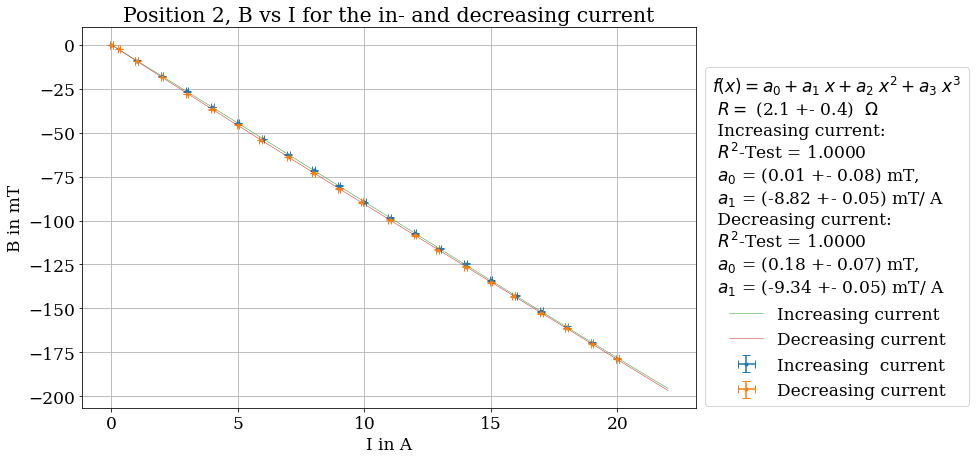

Increasing current: 
 R^2 = 0.9999874937564952 
 a0 = -0.10260879345594133 +- 0.10356072058703363 mT,
 a1 = -9.125276430760069 +- 0.07562524248063181 mT/A, 
 a2 = -0.00892465123652819 +- 0.011684838449733014 mT/A^2,
 a3 = 0.00029940386907336276 +- 0.00045712204250596345 mT/A^3
Decreasing current: 
 R^2 = 0.999982509494198 
 a0 = 0.1879632544630569 +- 0.09504155045496097 mT,
 a1 = -9.606258667459551 +- 0.06916929508024947 mT/A, 
 a2 = 0.03242782218007972 +- 0.010581251646651121 mT/A^2,
 a3 = -0.000667099114320116 +- 0.0004102049102377985 mT/A^3


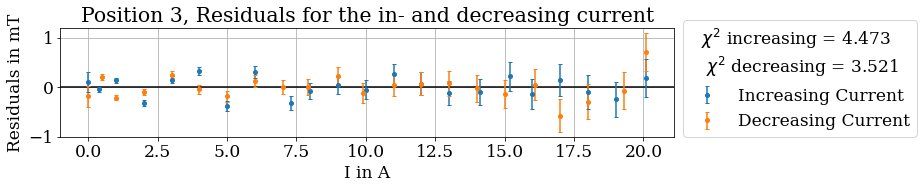

[-9.13, 0.08]


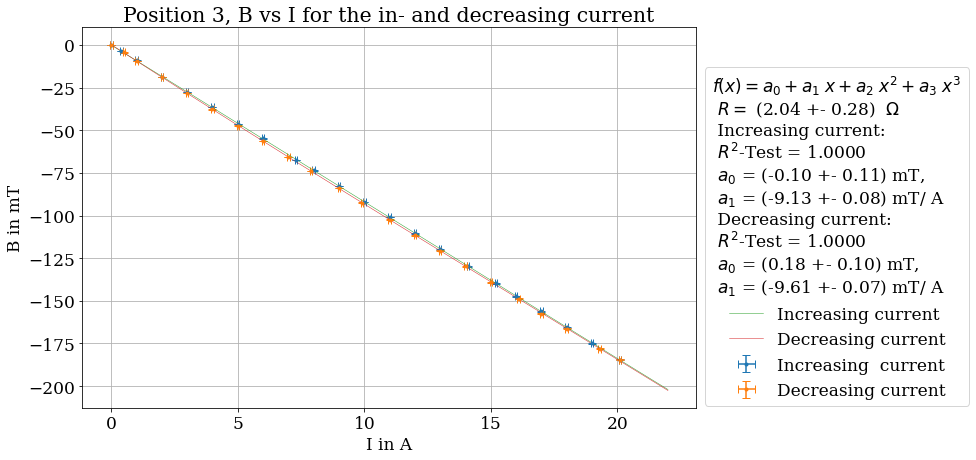

Increasing current: 
 R^2 = 0.999982985485053 
 a0 = 0.015324987501371633 +- 0.0046601205593425725 mT,
 a1 = -0.34182221639032945 +- 0.0026626026206404045 mT/A, 
 a2 = -0.0025051778775910614 +- 0.0003761226274688014 mT/A^2,
 a3 = 7.461078939514714e-05 +- 1.3917057668836217e-05 mT/A^3
Decreasing current: 
 R^2 = 0.9999831261455314 
 a0 = -0.009245694344621419 +- 0.005243742787282699 mT,
 a1 = -0.37589766245294826 +- 0.0028492301957652702 mT/A, 
 a2 = -0.0008562354031986614 +- 0.0003830983289991187 mT/A^2,
 a3 = 7.783241543236746e-05 +- 1.3756528570471113e-05 mT/A^3


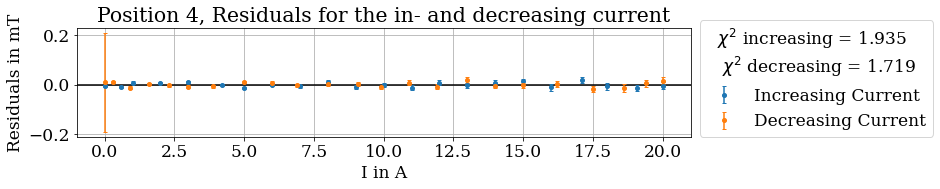

[-0.3418, 0.0027]


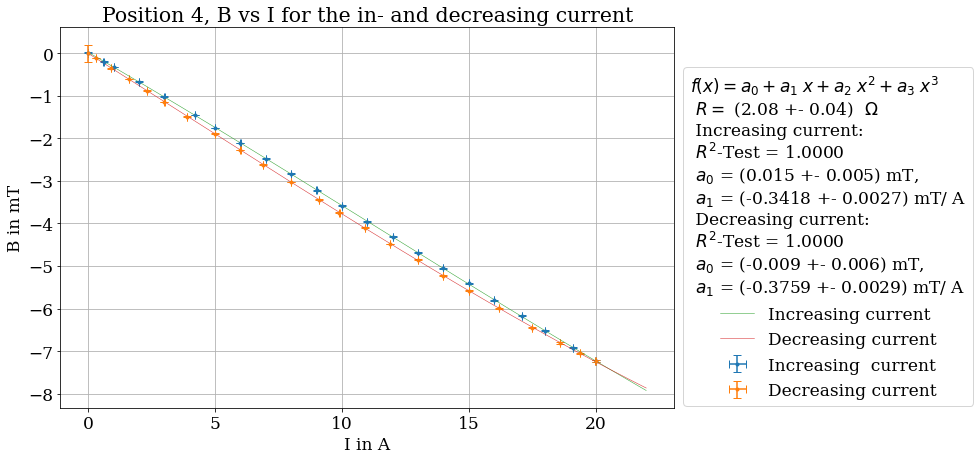

In [4]:
ParamterFitB("Messung1.dat", Windungen = 4, Stoff = "Iron", AllInOne = False, Pos = 1, Text = True, Fit = True)

print("\nM2")
ParamterFitB("Messung2.dat", Windungen = 5, Stoff = "Iron", AllInOne = False, Pos = 1, Text = True, Fit = True)

ParamterFitB("Messung3.dat", Windungen = 1000, Stoff = "Iron", AllInOne = False, Pos = 2, Text = True, Fit = True)

ParamterFitB("Messung4.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 3, Text = True, Fit = True)

ParamterFitB("Messung5.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 4, Text = True, Fit = True)
print()

In [5]:
def ParamterFitI(dataGemessen, Messdatenausgabe = False, Pos = 1, Windungen = 250, Stoff = "SteelIronStell", CST = True, Fit = False, AllInOne = False, Plot = True, Text = True, Datenausgabe = True, **kwargs):
    """
    dataGemessen = Gemessene Daten. Als "Messung1.dat" reingeben
    dataSimulation = von CST errechnete Daten. Als "MessungPos1Steel1008.dat" reingeben
    Pos = 1, 2, 3, 4 Position im Magneten 
    Windungen = 250 errechnete Windungszahl
    Stoff = "Steel1008" nur für Legende 
    CST = True, falls True werden simulierte Daten mit in den Plot gegeben (nur falls Plot = True)
    Fit = False, falls True wird die Regressionsgerade mit in den Plot gegeben  (nur falls Plot = True)
    AllInOne = False, falls True werden alle Daten in einem Plot geplottet (falls mehrere Male diese Funtion in einer Zelle aufgerufen wird) (nur falls Plot = True)
    Plot = True, falls True wird geplottet
    Text = True, falls True wird Text (Für den Hinweg: a0 = 0.5374802725263685 +- 0.012169832930567406, ...) mit ausgegeben 
    Datenausgabe = True, falls True wird R, Fitparameter ([[[a0h, ua0h], [a1h, ua1h], ...], [[a0r, ua0r], [a1r, ua1r], ...]]) mit ausgegeben 
    Messdatenausgabe = False, falls True werden die Daten vom gemessenen plus ihre Unsicherheiten ausgegegeben 
    """
    
#----------------------------------------------    
  #          LADEN DER WERTE 

    dataGemessen = np.transpose(np.genfromtxt(f"{dataGemessen}", skip_header = 2, skip_footer = 1))
    
    if 'dataSimulation' in kwargs:
        dataSimulation = np.transpose(np.genfromtxt(kwargs["dataSimulation"], skip_header = 2, skip_footer = 2))
        
    if 'Messung2' in kwargs:
        dataGemessen2 = np.transpose(np.genfromtxt(kwargs["Messung2"], skip_header = 2, skip_footer = 1))

    #----------------------------------------------    
    #          FEHLER DER WERTE
    # nachzulesen in meiner Datei, wie ich darauf kam
    
    # Systematischer Fehler

    if Pos == 4: 
        k_sys = -0.1 #mT

    else:
        k_sys = -1.0 #mT

    #Ablesefehle
    if Pos == 4: #nur bei der vierten Messung anders gewesen
        u_Ab = 0.005
    else: 
        u_Ab = 0.05

    #Gerätefehler der einzelnen Messgeräte - MÜSSEN NOCH ERGÄNZT WERDEN MIT ECHTEN WERTEN 
    u_GA = 0* 0.002 * dataGemessen[0] # jetzt 0 erstmal #Sage 2% vom Wert, idk tho
    u_GH = 0* 0.002 * (dataGemessen[1] - k_sys)
    u_GV = 0* 0.002 * dataGemessen[2]

    #Pytagoräische Addition der Fehler
    uI = np.sqrt(u_Ab**2 + u_GA**2) 
    uB = np.sqrt(u_Ab**2 + u_GH**2) 
    uU = np.sqrt(u_Ab**2 + u_GV**2)

    if 'Messung2' in kwargs:    
        #Gerätefehler der einzelnen Messgeräte - MÜSSEN NOCH ERGÄNZT WERDEN MIT ECHTEN WERTEN 
        u_GA2 = 0* 0.002 * dataGemessen2[0] # jetzt 0 erstmal #Sage 2% vom Wert, idk tho
        u_GH2 = 0.001 * (dataGemessen2[1] - k_sys) #1%+-2d
        u_GV2 = 0* 0.002 * dataGemessen2[2]

        print(u_GH2)
        
        #Pytagoräische Addition der Fehler
        uI2 = np.sqrt(u_Ab**2 + u_GA2**2) 
        uB2 = np.sqrt(u_Ab**2 + u_GH2**2) 
        uU2 = np.sqrt(u_Ab**2 + u_GV2**2)

#----------------------------------------------    
    #          SORTIEREN DER WERTE        
        
    index = np.where(dataGemessen[1] == min(dataGemessen[1]))[0][0]   # gehe immer bis zum einschließlich maximalen Wert hoch, dann von dort aus wieder runter
    
    # Nehme den ersten Messwert raus, weil der bei keiner Spannung kam    
    I = dataGemessen[0] #A
    uI = uI

    for i in range(len(I)):
        if I[i] == 0:
            I[i] = 10**(-20)
    
    
    B = dataGemessen[1] - k_sys #Ziehe systematischen Fehler ab
    uB = uB

    U = dataGemessen[2]
    uU = uU
   
    if 'dataSimulation' in kwargs:
        ISim = dataSimulation[1] / Windungen #A
        BSim = dataSimulation[Pos + 2] * 1000 #mT
        
    if 'Messung2' in kwargs: 
        
        index2 = np.where(dataGemessen2[1] == min(dataGemessen2[1]))[0][0]   # gehe immer bis zum einschließlich maximalen Wert hoch, dann von dort aus wieder runter

        # Nehme den ersten Messwert raus, weil der bei keiner Spannung kam    
        I2 = dataGemessen2[0] 
        uI2 = uI2 

        for i in range(len(I2)):
            if I2[i] == 0:
                I2[i] = 10**(-20)
    
        
        B2 = dataGemessen2[1] - k_sys #Ziehe systematischen Fehler ab
        uB2 = uB2

        U2 = dataGemessen2[2]
        uU2 = uU2
        
#----------------------------------------------
    #          FITTEN DER WERTE
    
    def reg(B, a0, a1, a2, a3):
        return a0 +  a1 * B +  a2 * B**2 +  a3 * B**3


    x = B[:index+1]
    y = I[:index+1]
    uy = uI[:index+1]
    popt, pcov = scipy.optimize.curve_fit(reg, x, y, sigma = uy) 
    a0h, a1h, a2h, a3h = popt
    ua0h, ua1h, ua2h, ua3h = np.sqrt(np.diag(pcov))
    residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
    r_squaredh = 1 - (ss_res / ss_tot)
    

    
    if Text == True:
        print(f"Increasing current: \n R^2 = {r_squaredh} \n a0 = {a0h} +- {ua0h},\n a1 = {a1h} +- {ua1h}, \n a2 = {a2h} +- {ua2h},\n a3 = {a3h} +- {ua3h}")

    x = B[index:]
    y = I[index:]
    uy = uI[index:]
    popt, pcov = scipy.optimize.curve_fit(reg, x, y, sigma = uy) 
    a0r, a1r, a2r, a3r= popt
    ua0r, ua1r, ua2r, ua3r = np.sqrt(np.diag(pcov))
    residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
    r_squaredr = 1 - (ss_res / ss_tot)
    

    if Text == True:
        print(f"Decreasing current: \n R^2 = {r_squaredr} \n a0 = {a0r} +- {ua0r} A,\n a1 = {a1r} +- {ua1r}, \n a2 = {a2r} +- {ua2r},\n a3 = {a3r} +- {ua3r}")
    
    
    if 'Messung2' in kwargs:
        x = B2[:index2+1]
        y = I2[:index2+1]
        uy = uI2[:index2+1]
        popt, pcov = scipy.optimize.curve_fit(reg, x, y , sigma = uy) 
        a0h2, a1h2, a2h2, a3h2 = popt
        ua0h2, ua1h2, ua2h2, ua3h2 = np.sqrt(np.diag(pcov))
        residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
        r_squaredh2 = 1 - (ss_res / ss_tot)

        if Text == True:
            print(f"Increasing current: \n R^2 = {r_squaredh2} \n a02 = {a0h2} +- {ua0h2},\n a12 = {a1h2} +- {ua1h2}, \n a22 = {a2h2} +- {ua2h2},\n a32 = {a3h2} +- {ua3h2}")

        x = B2[index2:]
        y = I2[index2:]
        uy = uI2[index2:]
        popt, pcov = scipy.optimize.curve_fit(reg, x, y, sigma = uy) 
        a0r2, a1r2, a2r2, a3r2= popt
        ua0r2, ua1r2, ua2r2, ua3r2 = np.sqrt(np.diag(pcov))
        residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
        r_squaredr2 = 1 - (ss_res / ss_tot)

        if Text == True:
            print(f"Decreasing current: \n R^2 = {r_squaredr2} \n a02 = {a0r2} +- {ua0r2},\n a12 = {a1r2} +- {ua1r2}, \n a22 = {a2r2} +- {ua2r2},\n a32 = {a3r2} +- {ua3r2}")

    
    if 'dataSimulation' in kwargs:

        x = BSim
        y = ISim
        popt, pcov = scipy.optimize.curve_fit(reg, x, y) 
        a0S, a1S, a2S, a3S= popt
        ua0S, ua1S, ua2S, ua3S = np.sqrt(np.diag(pcov))
        residuals = y- reg(x, *popt) # residual sum of squares  https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2) # total sum of squares 
        r_squareds = 1 - (ss_res / ss_tot)
    

        if Text == True:
            print(f"Simulation: \n R^2 = {r_squareds} \n a0 = {a0r} +- {ua0r},\n a1 = {a1r} +- {ua1r}, \n a2 = {a2r} +- {ua2r},\n a3 = {a3r} +- {ua3r}")

    x = np.linspace(-200, 0, 1000) # für Fit
    
    
#----------------------------------------------
    #          KLEINE RECHNUNGEN    
    
    
    R = np.mean(U / I)
    u_R =max(np.sqrt((uU / I)**2 + (- U / I**2 * uI)**2)) #rechne maximale Unsicherheit von R aus

    
    if 'Messung2' in kwargs:
        R2 = np.mean(U2 / I2)
        u_R2 =max(np.sqrt((uU2 / I2)**2 + (- U2 / I2**2 * uI2)**2)) #rechne maximale Unsicherheit von R aus


#----------------------------------------------
    #          PLOTTEN DER WERTE
    
    plt.rc('font', family = 'serif')
    if Plot == True:
        
        plt.errorbar(B[:index+1], I[:index+1], uI[:index+1], uB[:index+1], "+", markersize = 14, label = "Measurement, increasing  current")
        plt.errorbar(B[index:], I[index:], uI[index:], uB[index:], "+", markersize = 14, label = "Measurement, decreasing current")
        
        if 'dataSimulation' in kwargs:
            if CST == True:
                plt.plot(BSim, ISim, "+", label = f"Simulation, Material: {Stoff}", color = "black")
        
        if 'Messung2' in kwargs:
            plt.errorbar(B2[:index2+1], I2[:index2+1], uI2[:index2+1], uB2[:index2+1], "+", markersize = 8, label = "Measurement 2, increasing  current")
            plt.errorbar(B2[index2:], I2[index2:], uI2[index2:], uB2[index2:], "+", markersize = 8, label = "Measurement 2, decreasing current")
       
        
        if Fit == True:
            plt.plot(x, reg(x, a0h, a1h, a2h, a3h), linestyle='-', linewidth=0.5, label = "Measurement Increasing current")
            plt.plot(x, reg(x, a0r, a1r, a2r, a3r), linestyle='-', linewidth=0.5, label = "Measurement Decreasing current")
            if 'Messung2' in kwargs:
                plt.plot(x, reg(x, a0h2, a1h2, a2h2, a3h2), linestyle='-', linewidth=0.5, label = "Measurement 2, Increasing current")
                plt.plot(x, reg(x, a0r2, a1r2, a2r2, a3r2), linestyle='-', linewidth=0.5, label = "Measurement 2,Decreasing current")
           
                
        fontsize = 12   

        plt.xlabel("B in mT", fontsize = fontsize)
        plt.ylabel("I in A", fontsize = fontsize)

        plt.rcParams['figure.figsize'] = (11, 7)
        plt.title(f"Position {Pos}, I vs B for the in- and decreasing current")
        
        if 'dataSimulation' in kwargs:
            if 'Messung2' in kwargs:
                plt.legend(loc = (0.03, 0.005), title = f"$f(x) = a_0 + a_1 \; x + a_2 \; x^2 + a_3 \; x^3$ \n $R =$ ({R:.4f} +- {u_R:.4f})  Ohm \n Increasing current: \n $R^2$ = {r_squaredh:.4f} \n $a_0$ = ({a0h:.4f} +- {ua0h:.4f}) A, \n $a_1$ = ({a1h:.4f} +- {ua1h:.4f}) A/mT \n Decreasing current: \n $R^2$ = {r_squaredr:.4f} \n $a_0$ = ({a0r:.4f} +- {ua0r:.4f}) A, \n $a_1$ = ({a1r:.4f} +- {ua1r:.4f}) A/mT \n Measurement 2 \n $R_2 =$ ({R2:.4f} +- {u_R2:.4f})  Ohm \n Increasing current: \n $R^2$ = {r_squaredh:.4f}\n $a_2 0$ = ({a0h2:.4f} +- {ua0h2:.4f}) A, \n $a_2 1$ = ({a1h2:.4f} +- {ua1h2:.4f}) A/mT \n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_2 0$ = ({a0r2:.4f} +- {ua0r2:.4f}) A, \n $a_2 1$ = ({a1r2:.4f} +- {ua1r2:.4f}) A/mT \n Simulation \n $R^2$ = {r_squareds:.4f}\n $a_0$ = ({a0S:.4f} +- {ua0S:.4f}) A, \n $a_1$ = ({a1S:.4f} +- {ua1S:.4f}) A/mT", bbox_to_anchor=(1, 0., 0.5, 1),title_fontsize = fontsize,  fontsize = fontsize)
            else:
                plt.legend(loc = (0.03, 0.005), title = f"$f(x) = a_0 + a_1 \; x + a_2 \; x^2 + a_3 \; x^3$ \n $R =$ ({R:.4f} +- {u_R:.4f})  Ohm \n Increasing current: \n $R^2$ = {r_squaredh:.4f} \n $a_0$ = ({a0h:.4f} +- {ua0h:.4f}) A, \n $a_1$ = ({a1h:.4f} +- {ua1h:.4f}) A/mT\n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_0$ = ({a0r:.4f} +- {ua0r:.4f}) A, \n $a_1$ = ({a1r:.4f} +- {ua1r:.4f}) A/mT \n Simulation: \n $R^2$ = {r_squareds:.4f} \n $a_0$ = ({a0S:.4f} +- {ua0S:.4f}) A, \n $a_1$ = ({a1S:.4f} +- {ua1S:.4f}) A/mT", bbox_to_anchor=(1, 0., 0.5, 1),title_fontsize = fontsize,  fontsize = fontsize)
        else:
            if 'Messung2' in kwargs:
                plt.legend(loc = (0.03, 0.005), title = f"$f(x) = a_0 + a_1 \; x + a_2 \; x^2 + a_3 \; x^3$ \n $R =$ ({R:.4f} +- {u_R:.4f})  Ohm \n Increasing current: \n $R^2$ = {r_squaredh:.4f} \n $a_0$ = ({a0h:.4f} +- {ua0h:.4f}) A, \n $a_1$ = ({a1h:.4f} +- {ua1h:.4f}) A/mT \n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_0$ = ({a0r:.4f} +- {ua0r:.4f}) A, \n $a_1$ = ({a1r:.4f} +- {ua1r:.4f}) A/mT \n Measurement 2 \n $R_2 =$ ({R2:.4f} +- {u_R2:.4f})  Ohm \n Increasing current: \n $R^2$ = {r_squaredh:.4f}\n $a_2 0$ = ({a0h2:.4f} +- {ua0h2:.4f}) A, \n $a_2 1$ = ({a1h2:.4f} +- {ua1h2:.4f}) A/mT \n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_2 0$ = ({a0r2:.4f} +- {ua0r2:.4f}) A, \n $a_2 1$ = ({a1r2:.4f} +- {ua1r2:.4f}) A/mT", bbox_to_anchor=(1, 0., 0.5, 1),title_fontsize = fontsize,  fontsize = fontsize)

            else:
                plt.legend(loc = (0.03, 0.005), title = f"$f(x) = a_0 + a_1 \; x + a_2 \; x^2 + a_3 \; x^3$ \n $R =$ ({R:.4f} +- {u_R:.4f})  Ohm \n Increasing current: \n $R^2$ = {r_squaredh:.4f} \n $a_0$ = ({a0h:.4f} +- {ua0h:.4f}) A, \n $a_1$ = ({a1h:.4f} +- {ua1h:.4f}) A/mT \n Decreasing current: \n $R^2$ = {r_squaredr:.4f}\n $a_0$ = ({a0r:.4f} +- {ua0r:.4f}) A, \n $a_1$ = ({a1r:.4f} +- {ua1r:.4f}) A/mT", bbox_to_anchor=(1, 0., 0.5, 1),title_fontsize = fontsize,  fontsize = fontsize)
        
        plt.grid()
        
        if AllInOne == False:
            plt.show()
        
#----------------------------------------------
    #          AUSGABE DER WERTE
     
    if Messdatenausgabe == True:
        if 'dataSimulation' in kwargs:
            return [[B, uB], [I, uI], [U, uU]], [[[a0h, ua0h], [a1h, ua1h], [a2h, ua2h], [a3h, ua3h]], [[a0r, ua0r], [a1r, ua1r], [a2r, ua2r], [a3r, ua3r]], [[a0S, ua0S], [a1S, ua1S], [a2S, ua2S], [a3S, ua3S]]]
   
    
        else:
            return [[B, uB], [I, uI], [U, uU]], [[[a0h, ua0h], [a1h, ua1h], [a2h, ua2h], [a3h, ua3h]], [[a0r, ua0r], [a1r, ua1r], [a2r, ua2r], [a3r, ua3r]]]
    
        
        
    if Datenausgabe == True:
        
        if 'dataSimulation' in kwargs:
            return R, [[[a0h, ua0h], [a1h, ua1h], [a2h, ua2h], [a3h, ua3h]], [[a0r, ua0r], [a1r, ua1r], [a2r, ua2r], [a3r, ua3r]], [[a0S, ua0S], [a1S, ua1S], [a2S, ua2S], [a3S, ua3S]]]
   
    
        else:
            return R, [[[a0h, ua0h], [a1h, ua1h], [a2h, ua2h], [a3h, ua3h]], [[a0r, ua0r], [a1r, ua1r], [a2r, ua2r], [a3r, ua3r]]]
    
    

Increasing current: 
 R^2 = 0.999992958644795 
 a0 = 0.07142723642797696 +- 0.010393123442763504,
 a1 = -0.11147236178232386 +- 0.0005704644496866503, 
 a2 = 4.735578986534697e-06 +- 7.788772859914471e-06,
 a3 = 1.443326876453065e-08 +- 2.928523346985043e-08
Decreasing current: 
 R^2 = 0.9999863933474917 
 a0 = -0.0328960669767568 +- 0.016296760614931433 A,
 a1 = -0.10952213767145401 +- 0.0008733521088664384, 
 a2 = 1.7148259547204437e-05 +- 1.189633865448995e-05,
 a3 = 1.1090773831537605e-08 +- 4.4359437287697855e-08


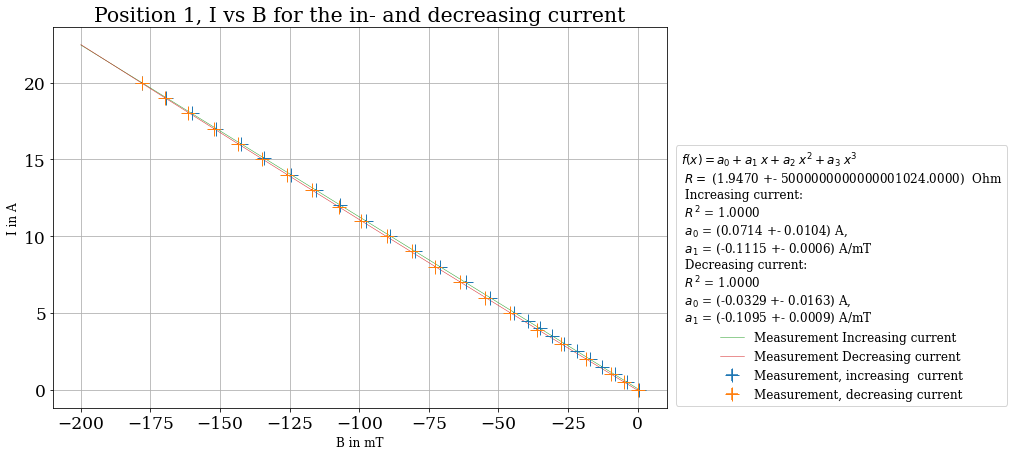

Increasing current: 
 R^2 = 0.9999769062538666 
 a0 = 0.01877478354414794 +- 0.02176994945122393,
 a1 = -0.11115879050644956 +- 0.001180215992783894, 
 a2 = 1.3696971977091743e-05 +- 1.5796797725673983e-05,
 a3 = 4.6486300582112156e-08 +- 5.800192292005309e-08
Decreasing current: 
 R^2 = 0.9999856976519168 
 a0 = -0.004594294276087942 +- 0.01749204102419409 A,
 a1 = -0.10933316151337451 +- 0.0008923244390851097, 
 a2 = 1.1062640166475631e-05 +- 1.195620056652503e-05,
 a3 = -2.8489382017060667e-08 +- 4.4169032929041824e-08


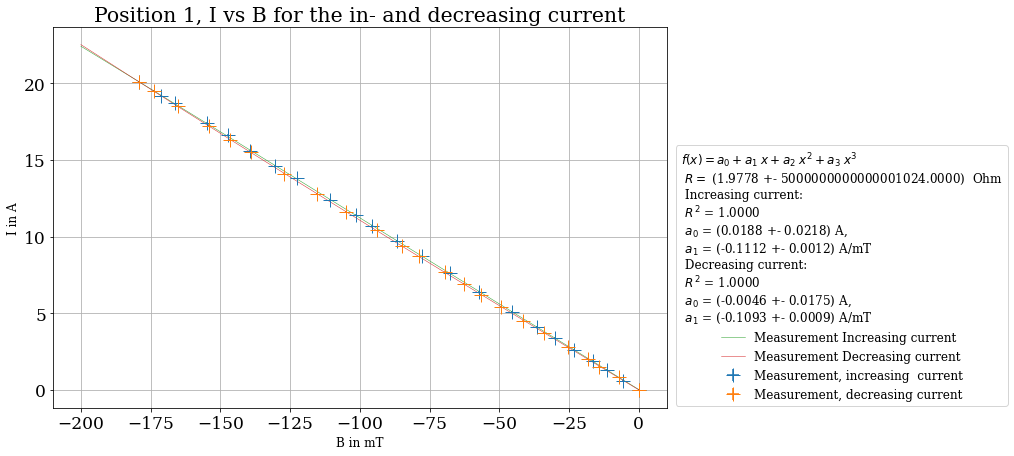

Increasing current: 
 R^2 = 0.9999924374015968 
 a0 = 0.014762425254122122 +- 0.013618259973475535,
 a1 = -0.11203094724615897 +- 0.0006786702255266651, 
 a2 = -3.961107228868317e-06 +- 8.961688495160682e-06,
 a3 = -2.0715291860991237e-08 +- 3.294666791021585e-08
Decreasing current: 
 R^2 = 0.999993943938682 
 a0 = 0.0032507144494352434 +- 0.010506990179939247 A,
 a1 = -0.10849469149625449 +- 0.0005635922441138456, 
 a2 = 1.8495934870892097e-05 +- 7.717618642819714e-06,
 a3 = -1.9976829074894543e-09 +- 2.885209032724888e-08


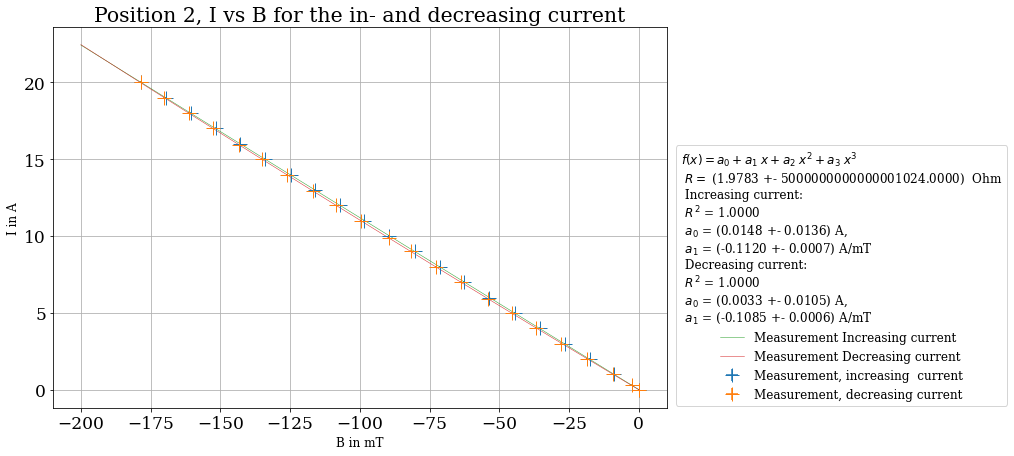

Increasing current: 
 R^2 = 0.9999875041413413 
 a0 = -0.007284023871470145 +- 0.015248205862463894,
 a1 = -0.10940749217852684 +- 0.0007959308351583676, 
 a2 = -9.623538605072713e-06 +- 1.0550478012223603e-05,
 a3 = -3.615025112800481e-08 +- 3.8205422530206526e-08
Decreasing current: 
 R^2 = 0.9999852790651921 
 a0 = 0.003944707055066453 +- 0.016810790607908136 A,
 a1 = -0.10531822615203403 +- 0.0008679244557689674, 
 a2 = 2.058650323219836e-05 +- 1.1412842151726869e-05,
 a3 = 1.4490607878350514e-08 +- 4.1032289603153046e-08


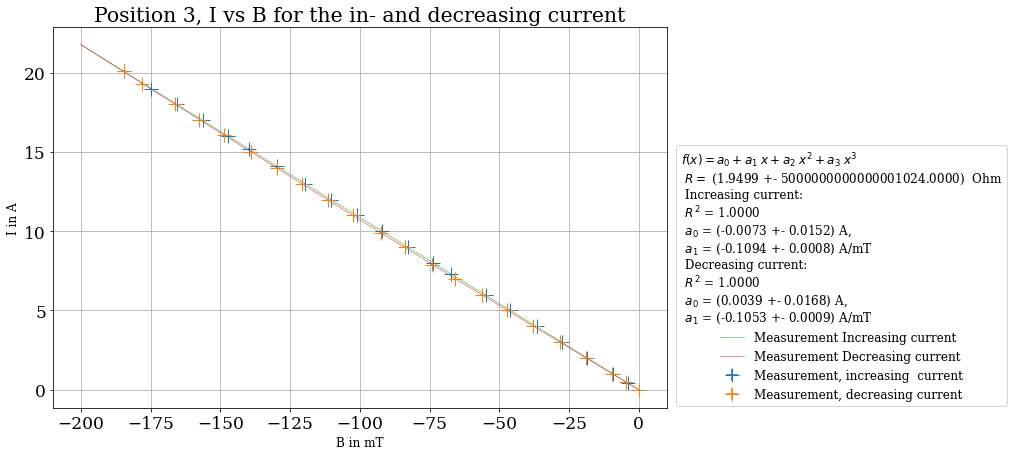

Increasing current: 
 R^2 = 0.9999829914420489 
 a0 = 0.05201817793402638 +- 0.0176452552510552,
 a1 = -2.898165391583474 +- 0.023574302053112124, 
 a2 = -0.046200636319559056 +- 0.007958486060250678,
 a3 = -0.0037144114583230418 +- 0.0007331018457844355
Decreasing current: 
 R^2 = 0.9999789417110131 
 a0 = -0.024922384096993284 +- 0.0194952871589148 A,
 a1 = -2.6790405018634993 +- 0.026617588281686578, 
 a2 = -0.026859426157384812 +- 0.008948941919158194,
 a3 = -0.0053001347123025995 +- 0.0008159018778154116


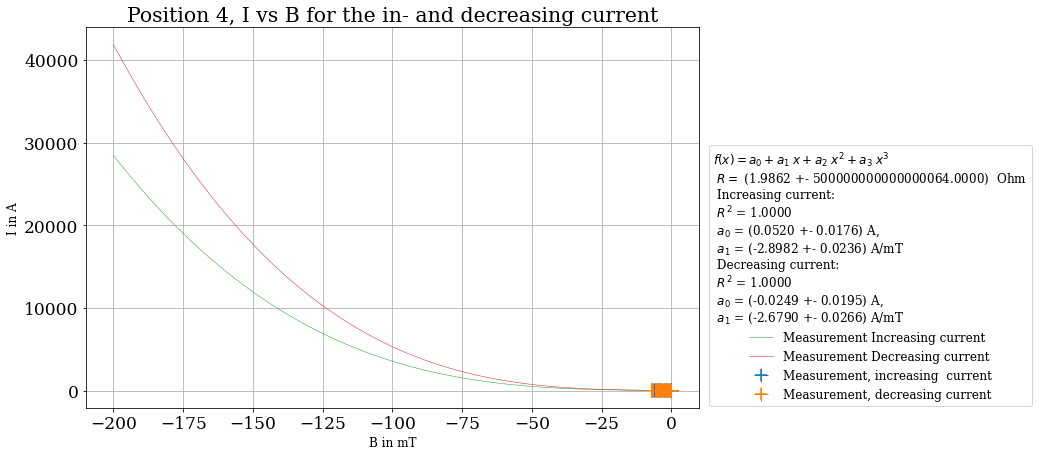

In [6]:
ParamterFitI("Messung1.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 1, Text = True, Fit = True)

ParamterFitI("Messung2.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 1, Text = True, Fit = True)

ParamterFitI("Messung3.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 2, Text = True, Fit = True)

ParamterFitI("Messung4.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 3, Text = True, Fit = True)

ParamterFitI("Messung5.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 4, Text = True, Fit = True)
print()

Getting the mean parameters

In [7]:
for number in range(1, 6):
    print(f"Mea9surement {number}:")
    means = []
    umeans = []
    print("Increase:")
    for i in range(4):
        print(fnc.roundingDIN(ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][0], ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][1], returnAsString = True)[0], "\pm", fnc.roundingDIN(ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][0], ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][1], returnAsString = True)[1])
    print("Decrease:")
    for i in range(4):
        print( fnc.roundingDIN(ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][0], ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][1], returnAsString = True)[0], "\pm", fnc.roundingDIN(ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][0], ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][1], returnAsString = True)[1])
           

Mea9surement 1:
Increase:
0.74 \pm 0.06
-9.01 \pm 0.05
0.006 \pm 0.007
-0.00017 \pm 0.00025
Decrease:
-0.38 \pm 0.07
-9.13 \pm 0.05
0.015 \pm 0.008
-0.00020 \pm 0.00029
Mea9surement 2:
Increase:
-0.07 \pm 0.17
-8.79 \pm 0.12
-0.020 \pm 0.017
0.0008 \pm 0.0007
Decrease:
0.10 \pm 0.15
-9.24 \pm 0.10
0.023 \pm 0.015
-0.0003 \pm 0.0006
Mea9surement 3:
Increase:
0.01 \pm 0.08
-8.82 \pm 0.05
-0.018 \pm 0.007
0.00068 \pm 0.00025
Decrease:
0.18 \pm 0.07
-9.34 \pm 0.05
0.032 \pm 0.008
-0.0007 \pm 0.0004
Mea9surement 4:
Increase:
-0.10 \pm 0.11
-9.13 \pm 0.08
-0.009 \pm 0.012
0.0003 \pm 0.0005
Decrease:
0.18 \pm 0.10
-9.61 \pm 0.07
0.032 \pm 0.011
-0.0007 \pm 0.0005
Mea9surement 5:
Increase:
0.922 \pm 0.008
-0.345 \pm 0.004
-0.0021 \pm 0.0004
 \pm 0.000013
Decrease:
0.888 \pm 0.008
-0.374 \pm 0.004
-0.0011 \pm 0.0005
8.6e-050 \pm 0.000014


In [8]:
Mean = []
uMean = []
for number in range(1, 6):
    print(f"Measurement {number}:")
    means = []
    umeans = []
    for i in range(4):
        means.append(np.mean([ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][0], ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][0]]))
        umeans.append(np.mean([ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][1], ParamterFitB(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][1]]))

    for i in np.array([0, 1, 2, 3]):
        print(f"a{i} = $", fnc.roundingDIN(means[i], umeans[i], returnAsString = True)[0], "\pm", fnc.roundingDIN(means[i], umeans[i], returnAsString = True)[1], "$")
        print(f"Relative value: a{i}/a1:  {means[i] / means[1] * 100:.4}\%")
    print("")
    Mean.append(means)
    uMean.append(umeans)
        
a0List, a1List, a2List, a3List = [], [], [], []
ua0List, ua1List, ua2List, ua3List = [], [], [], []
for i in range(5):
    a0List.append(Mean[i][0])
    a1List.append(Mean[i][1])
    a2List.append(Mean[i][2])
    a3List.append(Mean[i][3])
    
    ua0List.append(uMean[i][0])
    ua1List.append(uMean[i][1])
    ua2List.append(uMean[i][2])
    ua3List.append(uMean[i][3])

a0mean, ua0 = np.mean(a0List[1:-1]), max(ua0List[1:-1])
a1mean, ua1 = np.mean(a1List[1:-1]), max(ua1List[1:-1])
a2mean, ua2 = np.mean(a2List[1:-1]), max(ua2List[1:-1])
a3mean, ua3 = np.mean(a3List[1:-1]), max(ua3List[1:-1])

print("a0 = $", a0mean, "\pm", ua0, "$")
print("a1 = $", a1mean, "\pm", ua1, "$")
print("a2 = $", a2mean, "\pm", ua2, "$")
print("a3 = $", a3mean, "\pm", ua3, "$")


Measurement 1:
a0 = $ 0.18 \pm 0.07 $
Relative value: a0/a1:  -1.987\%
a1 = $ -9.07 \pm 0.05 $
Relative value: a1/a1:  100.0\%
a2 = $ 0.011 \pm 0.007 $
Relative value: a2/a1:  -0.1176\%
a3 = $ -0.00018 \pm 0.00027 $
Relative value: a3/a1:  0.002018\%

Measurement 2:
a0 = $ 0.02 \pm 0.16 $
Relative value: a0/a1:  -0.1909\%
a1 = $ -9.02 \pm 0.11 $
Relative value: a1/a1:  100.0\%
a2 = $ 0.001 \pm 0.016 $
Relative value: a2/a1:  -0.01272\%
a3 = $ 0.0002 \pm 0.0006 $
Relative value: a3/a1:  -0.002451\%

Measurement 3:
a0 = $ 0.09 \pm 0.08 $
Relative value: a0/a1:  -1.043\%
a1 = $ -9.08 \pm 0.05 $
Relative value: a1/a1:  100.0\%
a2 = $ 0.007 \pm 0.008 $
Relative value: a2/a1:  -0.07734\%
a3 = $  \pm 0.00028 $
Relative value: a3/a1:  -0.0001022\%

Measurement 4:
a0 = $ 0.04 \pm 0.10 $
Relative value: a0/a1:  -0.4557\%
a1 = $ -9.37 \pm 0.08 $
Relative value: a1/a1:  100.0\%
a2 = $ 0.012 \pm 0.012 $
Relative value: a2/a1:  -0.1255\%
a3 = $ -0.0002 \pm 0.0005 $
Relative value: a3/a1:  0.001963\%

In [9]:
#------------------------- for I(B) ---------------------------------

IMean = []
IuMean = []
for number in range(1, 6):
    print(f"Measurement {number}:")
    Imeans = []
    Iumeans = []
    for i in range(4):
        Imeans.append(np.mean([ParamterFitI(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][0], ParamterFitI(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][0]]))
        Iumeans.append(np.mean([ParamterFitI(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][1], ParamterFitI(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][1]]))

    for i in np.array([0, 1, 2, 3]):
        print(f"a{i} = $", fnc.roundingDIN(Imeans[i], (Iumeans[i]), returnAsString=True)[0], "\pm", fnc.roundingDIN(Imeans[i], Iumeans[i], returnAsString=True)[1], "$")
        print(f"Relative value: a{i}/a1:  {Imeans[i] / Imeans[1] * 100:.4}\%")
    print("")
    IMean.append(Imeans)
    IuMean.append(np.array(Iumeans))
        
Ia0List, Ia1List, Ia2List, Ia3List = [], [], [], []
Iua0List, Iua1List, Iua2List, Iua3List = [], [], [], []
for i in range(5):
    Ia0List.append(Mean[i][0])
    Ia1List.append(Mean[i][1])
    Ia2List.append(Mean[i][2])
    Ia3List.append(Mean[i][3])
    
    Iua0List.append(uMean[i][0])
    Iua1List.append(uMean[i][1])
    Iua2List.append(uMean[i][2])
    Iua3List.append(uMean[i][3])

Ia0mean, Iua0 = np.mean(Ia0List[1:-1]), max(Iua0List[1:-1])
Ia1mean, Iua1 = np.mean(Ia1List[1:-1]), max(Iua1List[1:-1])
Ia2mean, Iua2 = np.mean(Ia2List[1:-1]), max(Iua2List[1:-1])
Ia3mean, Iua3 = np.mean(Ia3List[1:-1]), max(Iua3List[1:-1])

print("a0 = $", Ia0mean, "\pm", Iua0, "$")
print("a1 = $", Ia1mean, "\pm", Iua1, "$")
print("a2 = $", Ia2mean, "\pm", Iua2, "$")
print("a3 = $", Ia3mean, "\pm", Iua3, "$")



Measurement 1:
a0 = $ 0.019 \pm 0.014 $
Relative value: a0/a1:  -17.44\%
a1 = $ -0.1105 \pm 0.0008 $
Relative value: a1/a1:  100.0\%
a2 = $ 1.09e-05 \pm 0.000010 $
Relative value: a2/a1:  -0.009902\%
a3 = $  \pm 0.00000004 $
Relative value: a3/a1:  -1.155e-05\%

Measurement 2:
a0 = $ 0.007 \pm 0.020 $
Relative value: a0/a1:  -6.431\%
a1 = $ -0.1102 \pm 0.0011 $
Relative value: a1/a1:  100.0\%
a2 = $ 1.2e-050 \pm 0.000014 $
Relative value: a2/a1:  -0.01123\%
a3 = $  \pm 0.00000006 $
Relative value: a3/a1:  -8.162e-06\%

Measurement 3:
a0 = $ 0.009 \pm 0.013 $
Relative value: a0/a1:  -8.168\%
a1 = $ -0.1103 \pm 0.0007 $
Relative value: a1/a1:  100.0\%
a2 = $  \pm 0.000009 $
Relative value: a2/a1:  -0.006591\%
a3 = $ - \pm 0.00000004 $
Relative value: a3/a1:  1.03e-05\%

Measurement 4:
a0 = $ -0.002 \pm 0.017 $
Relative value: a0/a1:  1.555\%
a1 = $ -0.1074 \pm 0.0009 $
Relative value: a1/a1:  100.0\%
a2 = $  \pm 0.000011 $
Relative value: a2/a1:  -0.005106\%
a3 = $ - \pm 0.00000004 $
Rel

## 1.2) Unsicherheit von B wegen der Position

In [10]:
def ContourPlot(data, stepsize = 2, bins = 20, **kwargs): 
    """
    Macht ContourPlot. Für mehrere y Ebenen, oder für nur eine y Ebene.
    Gebe eine Datei "data.txt" oder eine .dat Datei als "data" ein, 
    spezifiziere Pos1, Pos2, Pos3, Pos4, falls an vier verschiedenen Positionen interesse ist
    stepsize muss spezifieziert werden, wenn anders als 2
    """
    data = np.genfromtxt(f"{data}", skip_header = 2)  
    plt.rcParams['figure.figsize'] = [14, 12] 
    
    data = np.transpose(data)   # x, y, z, Bx, By, Bz
    x = data[0]
    y = data[1]
    z = data[2]
    By= data[4] * 1000

    heights = np.arange(min(y), max(y) +1 , stepsize) # alle Höhen aufgelistet 

    HeightsStorage = [[] for i in range(len(heights))] #gibt leere Liste für jede verschiedene Höhe aus.
    #Die wird gleich gefüllt mit Indexlisten für diese Höhe - damit ich auch 3D Plotten kann
    BGridStorage = [[] for i in range(len(heights))] # glcihes für das B-Feld-Grid


    for i in range(len(heights)):
        HeightsStorage[i] = np.where(y == heights[i])[0] 
        #gehe alle Höhen durch. Für jede Höhe werden die Indizes gesucht, wo diese Höhe aufkommt.

    x_lists =  [[] for i in range(len(heights))]
    z_lists =  [[] for i in range(len(heights))]
    By_lists =  [[] for i in range(len(heights))] 
    # gibt leere Liste für jede verschiedene Höhe aus. 
    # wird gleich gefüllt mit x, z, By Werten je Höhe


    for i in range(len(HeightsStorage)):  # für jede verschiedene Höhe
        for k in range(len(HeightsStorage[i])):  # für jeden Wert in dieser bestimmten Höhe
            x_lists[i].append(x[HeightsStorage[i][k]]) # die ite (Höhe) x-Liste wird erweitert mit mit k-ten Wert aller x-Werte
            z_lists[i].append(z[HeightsStorage[i][k]]) # die ite (Höhe) x-Liste wird erweitert mit mit k-ten Wert aller z-Werte
            By_lists[i].append(By[HeightsStorage[i][k]])


    for h in range(len(HeightsStorage)): # gehe alle Höhen durch
        xlist = np.arange(min(x_lists[h]), max(x_lists[h])+0.1, stepsize) #gibt Liste von minimalen bis maximalen Punkt in Stepsize
        zlist = np.arange(min(z_lists[h]), max(z_lists[h])+0.1, stepsize) # gibt z Liste von min bis max
        zsteps = len(z_lists[h])/len(zlist) # errechnet, wie viele Steps ingesamt gegangen werden        
        BGrid = [[] for k in range(len(zlist))]

        for i in range(0, int(len(xlist) * len(zlist)), int(zsteps)):
            BGrid[int(i/int(zsteps))] = By_lists[h][i:int(i+len(xlist))] #gibt len(xlist) * len(zlist) 
            #viele Listen aus, mit je zsteps B Werten drin
            #BGridStorage[h] = BGrid

            
        #fig = plt.figure()
        #ax1 = fig.add_subplot(111)
        #ax2 = ax1.twiny()
    
        #cp = ax1.contour(xlist, zlist, BGrid, bins)
        cp = plt.contour(-xlist, -zlist, BGrid, bins)
        
        #Titel mit und ohne kwargs
        if "Title" in kwargs:
            plt.title(f"{kwargs['Title']}\n Height: {heights[h]} mm")
        else:
            plt.title(f"Heights {heights[h]} mm")
    
        if ('Pos1' or 'Pos2' or 'Pos3' or 'Pos4') not in kwargs:
            xPos1 = ((max(xlist)-min(xlist))/2 + min(xlist))
            zPos1 = ((max(zlist)-min(zlist))/2 + min(zlist))
            print([xPos1, zPos1])
            plt.plot(-xPos1, -zPos1,'ro', markersize=11)
        
        for key, value in kwargs.items():
            if key != "Title":
                print("%s == %s" % (key, value))
                plt.plot(-kwargs[key][0], -kwargs[key][1], "ro", markersize=11)
                #plt.annotate('Something', xy=(kwargs[key][0], kwargs[key][1]))
                plt.text(-kwargs[key][0], -kwargs[key][1] + 9 , f'{key}')

            
        cbar = plt.colorbar(orientation = "horizontal", aspect = 40, pad=0.1)
        cbar.set_label('B in mT')
        plt.xlabel("x Position in mm")
        plt.ylabel("z Position in mm")
        plt.rcParams['figure.figsize'] = [14, 12]
        
        if kwargs["Title"] == "Position 1":
            for label in cbar.ax.xaxis.get_ticklabels()[1::2]:
                label.set_visible(False)
        
        plt.rcParams['axes.formatter.useoffset'] = False
        plt.clabel(cp, inline=True)
        if kwargs["Title"][0] == "P":
            plt.savefig(f'ContourPlotPos{kwargs["Title"][-1]}.svg', format='svg', dpi=1000, bbox_inches='tight')
        if kwargs["Title"][0] == "W":    
            plt.savefig(f'ContourPlotAlle.svg', format='svg', dpi=1000, bbox_inches='tight')
        
        plt.show()


Pos1 == [30.16, 94.2]
Pos2 == [-32.34, 200.2]
Pos3 == [-69.17, 191.5]
Pos4 == [-239.8, 8.2]


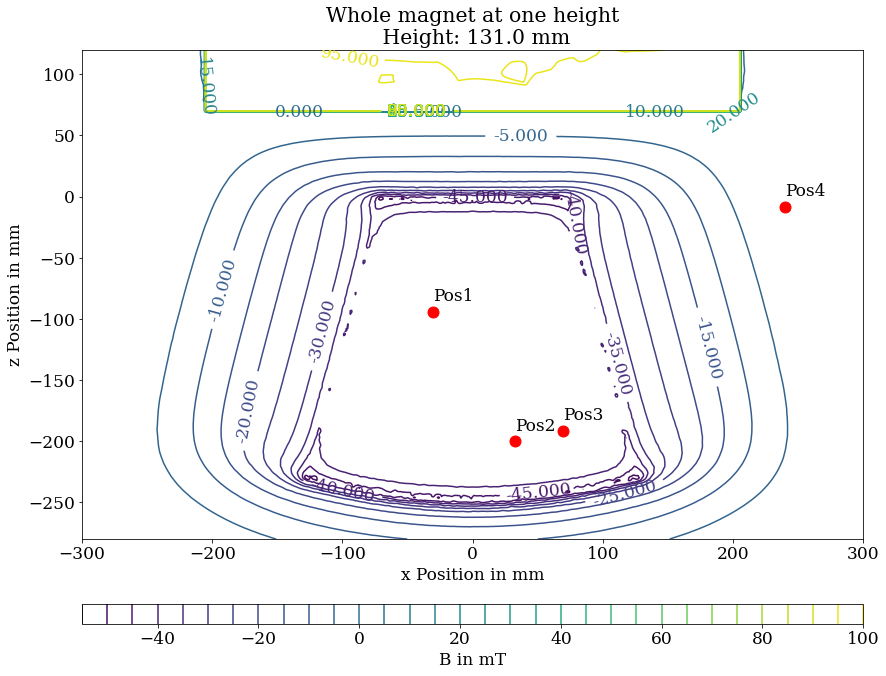

[-30.159999999999997, 94.2]


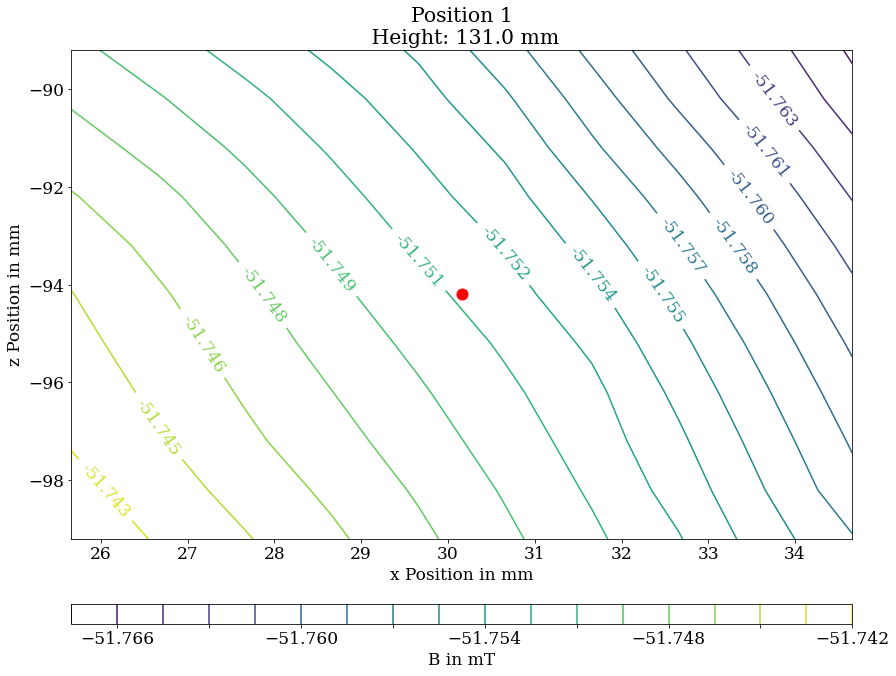

[32.34, 200.2]


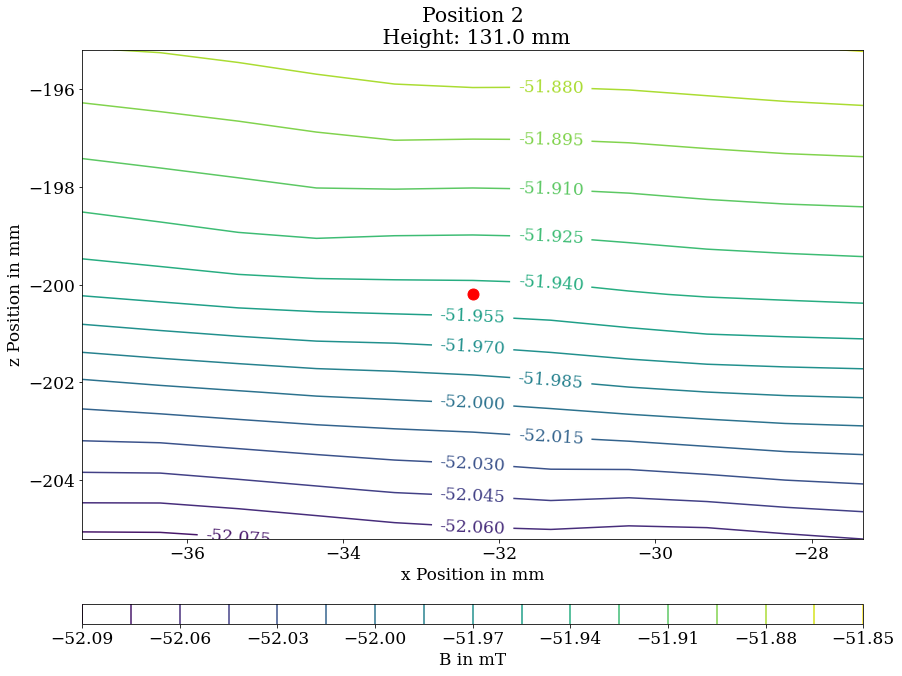

[69.17, 191.5]


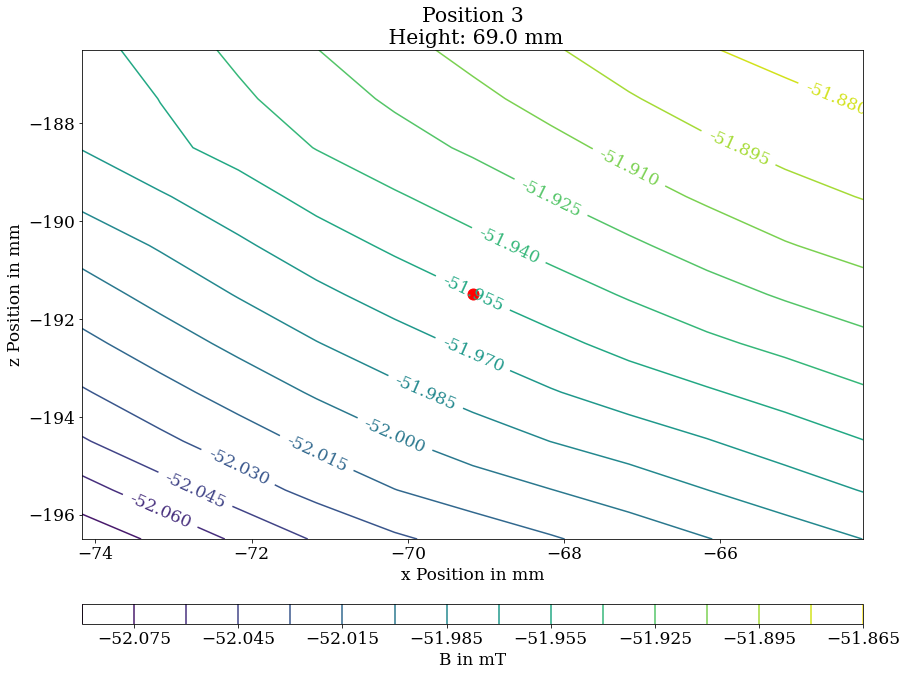

[239.8, 8.2]


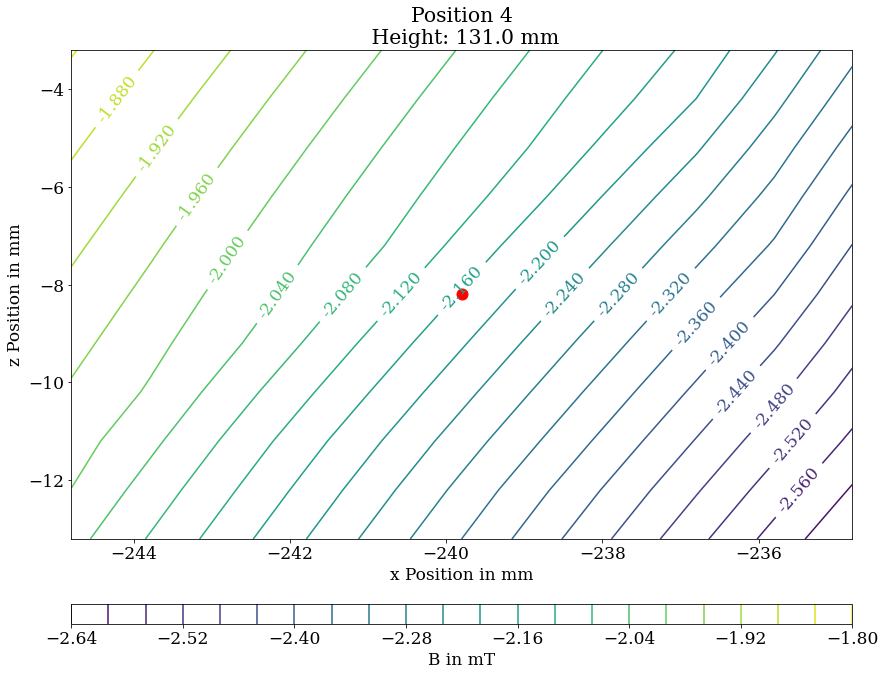

[-239.2, 10.129999999999999]


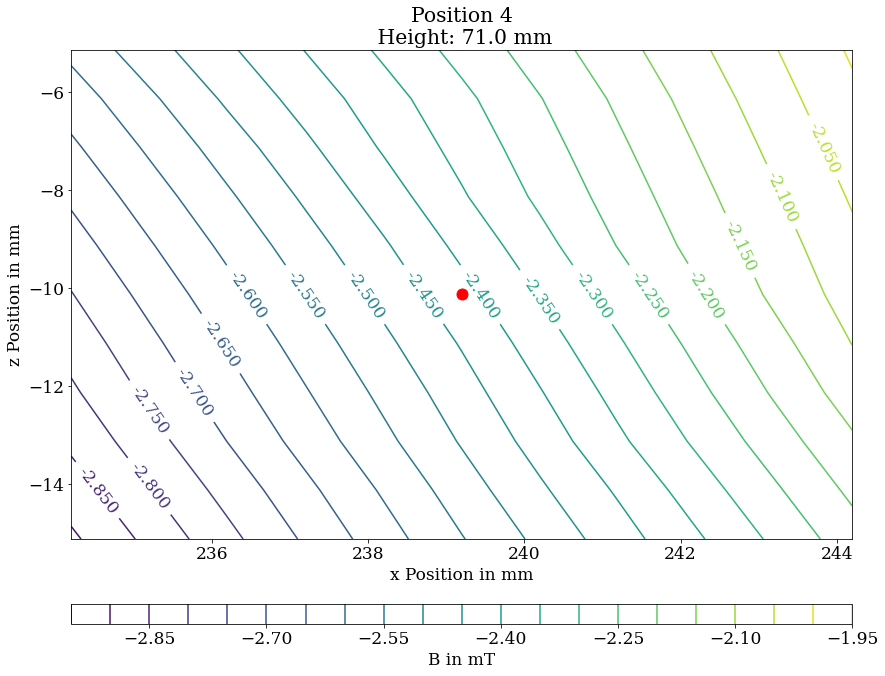

In [11]:
ContourPlot("B-Field [Ms]_All.txt", bins = 30,  stepsize = 1, Pos1 = [30.16, 94.2], Pos2 = [-32.34, 200.2], Pos3 = [-69.17, 191.5], Pos4 = [-239.8, 8.2], Title = "Whole magnet at one height")

#Pos1
ContourPlot("Pos1_B-Field [Ms].txt", stepsize = 1, Title ="Position 1")

#Pos2
ContourPlot("Pos2_B-Field [Ms].txt", stepsize= 1, Title ="Position 2")

#Pos3
ContourPlot("Pos3_B-Field [Ms].txt", stepsize = 1, Title ="Position 3")

# Pos 4
ContourPlot("Pos4_B-Field [Ms].txt", stepsize = 1, Title ="Position 4")
ContourPlot("Pos4_B-Field [Ms]_Height71.txt", stepsize = 1, Title ="Position 4")

In [12]:
def Anstieg(Data, stepsize = 1, mmZahl = 5, printing = False):
    """
    bekomme hiermit wie stark sich B ändert bei Bewegung in x und z Richtung
    """
    
    data = np.transpose(np.genfromtxt(f"{Data}", skip_header = 2))

    Schrittweite = max(data[0])-min(data[0])/stepsize # so viele Einträge gibt es mit dem gleichen z

    xLeft = data[0][0] 
    xRight = data[0][-1]
    zBottom = data[2][int(Schrittweite)]
    zTop = data[2][-1]
  
    xCenter = data[0][5*round(Schrittweite/2+0.5)]  # mitte x
    zCenter = data[2][round(len(data[2])/2 + 0.5)] # mitte z

    Center = np.where(np.logical_and(data[0] == xCenter, data[2] == zCenter))[0][0]
    Left = np.where(np.logical_and(data[0] == xLeft, data[2] == zCenter))[0][0]
    Right = np.where(np.logical_and(data[0] == xRight, data[2] == zCenter))[0][0]
    Bottom = np.where(np.logical_and(data[0] == xCenter, data[2] == zBottom))[0][0]
    Top = np.where(np.logical_and(data[0] == xCenter, data[2] == zTop))[0][0]
    
    BCenter = data[4][Center]
    BLeft = data[4][Left]
    BRight = data[4][Right]
    BBottom = data[4][Bottom]
    BTop = data[4][Top]
    
    SlopeLeft = (BCenter-BLeft)/(xCenter-xLeft)    # T/mm
    SlopeRight = (BRight-BCenter)/(xRight-xCenter)
    SlopeBottom = (BCenter-BBottom)/(zCenter-zBottom)    # T/mm
    SlopeTop = (BTop-BCenter)/(zTop-zCenter)
      
    Slopes = [SlopeLeft, SlopeTop, SlopeRight, SlopeBottom]
    
    zSlope = [SlopeTop, SlopeBottom]
    xSlope = [SlopeLeft, SlopeRight]
        
    if printing == True:
        print(f"Position {Data}")
        print(f"B field at 'exact' position: {BCenter * 1000} mT")
        print(f"Move {mmZahl} mm in -x direction: B value + ({((mmZahl * SlopeRight)*1000):.4f}) mT." )
        print(f"Move {mmZahl} mm in +x direction: B value + ({((-mmZahl * SlopeLeft)*1000):.4f}) mT.\n" )
        print(f"Move {mmZahl} mm in -z direction: B value + ({((mmZahl * SlopeTop)*1000):.4f}) mT." )
        print(f"Move {mmZahl} mm in +z direction: B value + ({((-mmZahl * SlopeBottom)*1000):.4f}) mT. \n" )
        #achtung, minus und plus mussten getauscht werden, weil ich oben den contourplot kompkett invertiert habe
        
    return [BCenter * 1000, max(abs(np.array([SlopeLeft, SlopeRight, SlopeBottom, SlopeTop]) * mmZahl * 1000))]

In [13]:
for i in range(4): 
    AnstiegPos = Anstieg(f"Pos{i+1}_B-Field [Ms].txt", mmZahl = 5, printing = True)
    print(f"Maximum relative change of {-AnstiegPos[1] / AnstiegPos[0] * 100:.4}%")
    print("\n")
    
AnstiegPos = Anstieg(f"Pos4_B-Field [Ms]_Height71.txt", mmZahl = 5, printing = True)
print(f"Maximum relative change of {-AnstiegPos[1] / AnstiegPos[0] * 100:.4}%")
print("\n")

Position Pos1_B-Field [Ms].txt
B field at 'exact' position: -51.750522000000004 mT
Move 5 mm in -x direction: B value + (0.0070) mT.
Move 5 mm in +x direction: B value + (-0.0106) mT.

Move 5 mm in -z direction: B value + (0.0029) mT.
Move 5 mm in +z direction: B value + (-0.0037) mT. 

Maximum relative change of 0.02042%


Position Pos2_B-Field [Ms].txt
B field at 'exact' position: -51.947873 mT
Move 5 mm in -x direction: B value + (-0.0160) mT.
Move 5 mm in +x direction: B value + (0.0072) mT.

Move 5 mm in -z direction: B value + (-0.1280) mT.
Move 5 mm in +z direction: B value + (0.0711) mT. 

Maximum relative change of 0.2464%


Position Pos3_B-Field [Ms].txt
B field at 'exact' position: -51.984094 mT
Move 5 mm in -x direction: B value + (-0.0560) mT.
Move 5 mm in +x direction: B value + (0.0422) mT.

Move 5 mm in -z direction: B value + (-0.0734) mT.
Move 5 mm in +z direction: B value + (0.0474) mT. 

Maximum relative change of 0.1412%


Position Pos4_B-Field [Ms].txt
B field at 

# 2) Calculate number of turns


$a = \frac{B}{I}$
$I = \frac{I_N}{N}$
    
\begin{align}
    \Rightarrow \quad N &= \frac{I_N}{B} \cdot a \\
    u_N &= \sqrt{(\frac{a}{B} u_{IN})^2 + (\frac{a I_N}{B^2} u_{B})^2 + (\frac{I_N}{B} u_{a})^2 }
\end{align}


In [14]:
def Windungen(DataMeasurement, DataSimulation, Position = 1, Spalten = 4):
    """
    DataMeasurement needs fit parameters as an array (e.g. use previously defined function ParamterFitB("Messung1.dat", dataSimulation = "RampeIron0Bis5300.txt", Windungen = Windungen, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]
)
    DataSimulation need to have IN in second column, columns 3, 4, 5, 6 need B1 - B4 
    """  
    a = np.mean([DataMeasurement[0][1][0],DataMeasurement[1][1][0]])
    ua = max([DataMeasurement[0][1][1], DataMeasurement[1][1][1]])

    data = np.transpose(np.genfromtxt(f"{DataSimulation}", skip_header = 1, skip_footer = 1))    

    if Spalten == 4:
        IN = data[1]
        B1 = data[2] * 1000 #T
        B2 = data[3] * 1000
        B3 = data[4] * 1000
        B4 = data[5] * 1000
        B = [B1, B2, B3, B4]

    else:
    # simulated b fields at positions  
        IN = data[1][1:]
        B1 = data[3][1:] * 1000 #T
        B2 = data[4][1:] * 1000
        B3 = data[5][1:] * 1000
        B4 = data[6][1:] * 1000
        B = [B1, B2, B3, B4]

    i = Position - 1
    
    AnstiegPos = Anstieg(f"Pos{i+1}_B-Field [Ms].txt", mmZahl = 5, printing = False)
    # uncertainties through uncertainties of positions at IN = 1246, N = 1:
    uIN = 10**(-3)
    uB = -AnstiegPos[1] / AnstiegPos[0]  # maximum relative error 
    B_New = [1, 1, 1, 1]
    
    
    for m in range(len(B1)): # take all B values into consideration which have been simulated at that position
        if B[i][m] == 0.:
            IN_New = np.delete(IN, m) # delete data with B = 0, so I can devide through everything
            B_New[i] = np.delete(B[i], m)
        else:
            IN_New = IN
            B_New[i] = B[i]
  
    # calculate N and uncertainties
    N = IN_New / B_New[i] * a
    uN = np.sqrt((a / B_New[i]  *  (uIN * IN_New))**2 + (IN_New * a / B_New[i]**2  *  (uB * B_New[i]))**2 + (IN_New / B_New[i]  * ua)**2)
    
    print(f"Position {Position} \n Calculate all N with the $a_1$ at that position. The take the average N and gaussian error propagaion max(uN): \n N = {np.mean(N)} +- { max(uN)}")

    #nutze a1List von oben, mit mit dem gemittelten a1 zu rechnen:
    aMean = np.mean(a1List[1:-1])
    uaMean = max(ua1List[1:-1])

    
    N_New = IN_New / B_New[i] * aMean
    uN_New = np.sqrt((aMean / B_New[i]  *  uIN)**2 + (IN_New * aMean / B_New[i]**2  *  (uB * B_New[i]))**2 + (IN_New / B_New[i]  * uaMean)**2)
    #print(f"\n Calculate the same way, but take mean(a_1) from all positions \n N = {np.mean(N_New)} +- {np.mean(uN_New)} \n\n")


    return [np.mean(N), max(uN)]

In [15]:
Pos1  = ParamterFitB("Messung2.dat", dataSimulation = "RampeIron_0Bis5300_Neu.txt", Windungen = 255, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos2  = ParamterFitB("Messung3.dat", dataSimulation = "RampeIron_0Bis5300_Neu.txt", Windungen = 255, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos3  = ParamterFitB("Messung4.dat", dataSimulation = "RampeIron_0Bis5300_Neu.txt", Windungen = 255, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos4  = ParamterFitB("Messung5.dat", dataSimulation = "RampeIron_0Bis5300_Neu.txt", Windungen = 255, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]

print("IRON:")
W1Iron = Windungen(Pos1, "RampeIron_0Bis5300_Neu.txt", Position = 1)

W2Iron = Windungen(Pos2, "RampeIron_0Bis5300_Neu.txt", Position = 2)

W3Iron = Windungen(Pos3, "RampeIron_0Bis5300_Neu.txt", Position = 3)

W4Iron = Windungen(Pos4, "RampeIron_0Bis5300_Neu.txt", Position = 4)



Pos1  = ParamterFitB("Messung2.dat", dataSimulation = "RampeSteel1008_0Bis5300_Neu.txt", Windungen = 250, Stoff = "Steel1008", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos2  = ParamterFitB("Messung3.dat", dataSimulation = "RampeSteel1008_0Bis5300_Neu.txt", Windungen = 250, Stoff = "Steel1008", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos3  = ParamterFitB("Messung4.dat", dataSimulation = "RampeSteel1008_0Bis5300_Neu.txt", Windungen = 250, Stoff = "Steel1008", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos4  = ParamterFitB("Messung5.dat", dataSimulation = "RampeSteel1008_0Bis5300_Neu.txt", Windungen = 250, Stoff = "Steel1008", Plot = False, Pos = 1, Text = False, Fit = True)[1]

print("\n\nSTEEL 1008:")
W1Steel1008 = Windungen(Pos1, "RampeSteel1008_0Bis5300_Neu.txt", Position = 1)

W2Steel1008 = Windungen(Pos2, "RampeSteel1008_0Bis5300_Neu.txt", Position = 2)

W3Steel1008 = Windungen(Pos3, "RampeSteel1008_0Bis5300_Neu.txt", Position = 3)

W4Steel1008 = Windungen(Pos4, "RampeSteel1008_0Bis5300_Neu.txt", Position = 4)




Pos1  = ParamterFitB("Messung2.dat", dataSimulation = "RampeSteel1010_0Bis5300_Neu.txt", Windungen = 250, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos2  = ParamterFitB("Messung3.dat", dataSimulation = "RampeSteel1010_0Bis5300_Neu.txt", Windungen = 250, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos3  = ParamterFitB("Messung4.dat", dataSimulation = "RampeSteel1010_0Bis5300_Neu.txt", Windungen = 250, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]
Pos4  = ParamterFitB("Messung5.dat", dataSimulation = "RampeSteel1010_0Bis5300_Neu.txt", Windungen = 250, Stoff = "Iron", Plot = False, Pos = 1, Text = False, Fit = True)[1]

print("\n\nSTEEL 1010:")
W1Steel1010 = Windungen(Pos1, "RampeSteel1010_0Bis5300_Neu.txt", Position = 1)

W2Steel1010 = Windungen(Pos2, "RampeSteel1010_0Bis5300_Neu.txt", Position = 2)

W3Steel1010 = Windungen(Pos3, "RampeSteel1010_0Bis5300_Neu.txt", Position = 3)

W4Steel1010 = Windungen(Pos4, "RampeSteel1010_0Bis5300_Neu.txt", Position = 4)

IRON:
Position 1 
 Calculate all N with the $a_1$ at that position. The take the average N and gaussian error propagaion max(uN): 
 N = 268.06648988936035 +- 6.46088405281666
Position 2 
 Calculate all N with the $a_1$ at that position. The take the average N and gaussian error propagaion max(uN): 
 N = 269.7941021599942 +- 3.2504127215976983
Position 3 
 Calculate all N with the $a_1$ at that position. The take the average N and gaussian error propagaion max(uN): 
 N = 275.85475003357755 +- 4.171642334499462
Position 4 
 Calculate all N with the $a_1$ at that position. The take the average N and gaussian error propagaion max(uN): 
 N = 257.0803947422057 +- 73.05703005579886


STEEL 1008:
Position 1 
 Calculate all N with the $a_1$ at that position. The take the average N and gaussian error propagaion max(uN): 
 N = 252.55011069309086 +- 3.2199686213368492
Position 2 
 Calculate all N with the $a_1$ at that position. The take the average N and gaussian error propagaion max(uN): 
 N = 2

In [16]:
unc = np.array([W1Iron[1], W2Iron[1], W3Iron[1], W4Iron[1]])
weights = 1/unc**2
weights

vals = np.array([W1Iron[0], W2Iron[0], W3Iron[0], W4Iron[0]])
added = []

for i in range(len(vals)):
    added.append(vals[i] * weights[i]  )
    
np.sum(added) / np.sum(weights)

271.52165213040854

In [17]:
d = 0.076 #0.068    #0.076 #m
ud = 0*0.00005
a1 = np.array(a1List) / 1000 #T/A
ua1v = np.array(ua1List)  / 1000
mu0 = 1.25663706212e-6

print(a1List)
print(a1mean)
a1 = a1mean / 1000
ua1v = ua1 / 1000

N = -d / mu0 * a1 
uN = np.sqrt((d/mu0 * ua1v )**2 + (-a1/mu0 * ud)**2)

#for i in range(len(N)):
#    print(N[i], uN[i])

print(N, uN)
print(N/2, uN/2)

277 - 4

[-9.067292281606012, -9.017048526340599, -9.080428476107858, -9.36576754910981, -0.3596582795523908]
-9.154414850519423
553.6487420367349 6.300333483190009
276.82437101836746 3.1501667415950045


273

# B(I), I(B)

In [18]:
def B(I):
    """
    takes I in A
    gives B in mT
    """
    
    Mean = []
    uMean = []
    for number in range(1,6):
        means = []
        umeans = []
        for i in range(4):
            means.append(np.mean([ParamterFitB(f"Messung{number}.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][0], ParamterFitB(f"Messung{number}.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][0]]))
            umeans.append(np.mean([ParamterFitB(f"Messung{number}.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][1], ParamterFitB(f"Messung{number}.dat", Windungen = 276, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][1]]))
        Mean.append(means)
        uMean.append(umeans)
 
    a0List, a1List, a2List, a3List = [], [], [], []
    ua0List, ua1List, ua2List, ua3List = [], [], [], []
    for i in range(5):
        a0List.append(Mean[i][0])
        a1List.append(Mean[i][1])
        a2List.append(Mean[i][2])
        a3List.append(Mean[i][3])

        ua0List.append(uMean[i][0])
        ua1List.append(uMean[i][1])
        ua2List.append(uMean[i][2])
        ua3List.append(uMean[i][3])

    a0mean, ua0 = np.mean(a0List[1:-1]), max(ua0List[1:-1])
    a1mean, ua1 = np.mean(a1List[1:-1]), np.sqrt(ua0List[1]**2+ua0List[2]**2+ua0List[3]**2)#max(ua1List[1:-1])
    a2mean, ua2 = np.mean(a2List[1:-1]), max(ua2List[1:-1])
    a3mean, ua3 = np.mean(a3List[1:-1]), max(ua3List[1:-1])
    
    #print(np.std(a1List[1:-1]))
    #print(np.mean(ua1List[1:-1]))
    #print(np.sqrt(ua0List[1]**2+ua0List[2]**2+ua0List[3]**2))
    uI = 0 
    uB = np.sqrt(ua0**2 + (I * ua1)**2 + (I**2 * ua2)**2 + (I**3 * ua3)**2 + ((a1mean + 2* a2mean * I + 3 * a3mean * I**2)*uI)**2)
    uB = np.sqrt((I * ua1)**2 + (a1mean*uI)**2)
    print(a1mean, ua1)
    # GEBE ABER NUR MIT A1 AN
    print(1/(a1mean))
    return [a1mean * I, uB]
B(1)

-9.154414850519423 0.19984764895564783
-0.10923691096905662


[-9.154414850519423, 0.19984764895564783]

In [19]:
def I(B, uB = 1):
    """
    takes B in mT
    gives I in A
    """
    
    Mean = []
    uMean = []
    for number in range(1,6):
        means = []
        umeans = []
        for i in range(4):
            means.append(np.mean([ParamterFitI(f"Messung{number}.dat", Windungen = 256, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][0], ParamterFitI(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][0]]))
            umeans.append(np.mean([ParamterFitI(f"Messung{number}.dat", Windungen = 256, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][0][i][1], ParamterFitI(f"Messung{number}.dat", Windungen = 255, Stoff = "Iron", AllInOne = False, Pos = 1, Text = False, Fit = True, Plot = False)[1][1][i][1]]))
             
        Mean.append(means)
        uMean.append(umeans)
 
    a0List, a1List, a2List, a3List = [], [], [], []
    ua0List, ua1List, ua2List, ua3List = [], [], [], []
    for i in range(5):
        a0List.append(Mean[i][0])
        a1List.append(Mean[i][1])
        a2List.append(Mean[i][2])
        a3List.append(Mean[i][3])

        ua0List.append(uMean[i][0])
        ua1List.append(uMean[i][1])
        ua2List.append(uMean[i][2])
        ua3List.append(uMean[i][3])
    
    # Hier die Standardabweichung nehmen ist nicht wirklich erlaubt - müsste eigentlich den größten Fehler nehmen
    a0mean, ua0 = np.mean(a0List[1:-1]), np.std(a0List[1:-1])
    a1mean, ua1 = np.mean(a1List[1:-1]), max(ua1List[1:-1]) #np.std(a1List[1:-1])
    a2mean, ua2 = np.mean(a2List[1:-1]), np.std(a2List[1:-1])
    a3mean, ua3 = np.mean(a3List[1:-1]), np.std(a3List[1:-1])
    
    uI = np.sqrt(ua0**2 + (B * ua1)**2 + (B**2 * ua2)**2 + (B**3 * ua3)**2 + ((a1mean + 2* a2mean * B + 3 * a3mean * B**2)*uB)**2)
    uI = np.sqrt((B * ua1)**2 + (a1mean*uB)**2)
    
    I = a0mean + a1mean * B + a2mean * B**2 + a3mean * B**3
    a1mean * B
    print(a1mean, ua1)
    return [a1mean * B, uI]

I(51.70)

-0.1092905515154664 0.0010362702159345018


[-5.650321513349613, 0.12171574881105739]

# 3) Get current in CST 

put N = 256
I = 1

Calculate the B field

Two ways:

- 1) Gleichmäßiges Grid (Stepwidth 2)

- 2) Ausgwertet nach Mesh 

- gehe dafür in jeweiligen Unterordner



# 4) Calculate Leff

In [20]:
Leff, uLeff =[335.20640620395164, 0.2958181993066121] #mm from other file (B an Trajektorie)

rho = Leff / np.sin(60/180*np.pi)
urho = np.sqrt((1/np.sin(60/180*np.pi) * uLeff)**2)
fnc.roundingDIN(rho, urho)


[387.1, 0.4]

# 5) Calculate Bapprox

Funktion, die ungefähres B Feld gibt, welches man braucht, um ein Elektron auf den Schirm zu lenken


In [21]:
def Bapprox(pc, upc = 0, printing = False):
    """
    pc in MeV
    gives B in T
    """
    
    c = 299.792458 
    sintheta = np.sin(60 / 180 * np.pi)
    Leffective = Leff/ 1000 #m
    uLeffective = uLeff / 1000
    # rho = Leff / sin(60)
    
    
    Bapprox = pc/c * sintheta /Leffective
    uBapprox = np.sqrt((sintheta/c * 1 /Leffective  * upc )**2 + (- sintheta/c * pc * Leffective**(-2) * uLeffective)**2)
    return [Bapprox, uBapprox]

np.array(Bapprox(6))

array([5.17069438e-02, 4.56311536e-05])

# 6) calculate I

Möchte wissen, welchen Strom ich brauhce, um ein Elektron mit momentum p auf den Schirm zu lenken

In [22]:
def StromApprox(p, Windungen = 276, printing = False):
    """p in MeV/c
    """
    
    BField = Bapprox(p, printing = False)[0] #T
    uBField = Bapprox(p, printing = False)[1] #T
    
    Current, uCurrent = I(- BField * 1000, uB = -uBField * 1000) #A
 
    INew = fnc.roundingDIN(Current, uCurrent, returnAsString = False)[0]
    uINew = fnc.roundingDIN(Current, uCurrent, returnAsString = False)[1]

    if printing == True:
        print(f"Reference particle with p = {p} MeV/c needs a magnetic field of B = ({BField} +- {uBField} ) T, \nso a current of I = ({INew} +- {uINew}) A.")
        print(f"These are {I(- 1000* BField)[0] * Windungen:.5} ampereturns.")

    return [INew, uINew]
    
StromApprox(6, Windungen = 256, printing = True)

-0.1092905515154664 0.0010362702159345018
Reference particle with p = 6 MeV/c needs a magnetic field of B = (0.05170694382067542 +- 4.5631153610393134e-05 ) T, 
so a current of I = (5.65 +- 0.06) A.
-0.1092905515154664 0.0010362702159345018
These are 1446.7 ampereturns.


[5.65, 0.06]

### don't forget the factor from ASTRA

In [23]:
k = -1.16775

BReal = np.array(Bapprox(6))* k * 1000 #mT

IReal = I(BReal[0], uB = BReal[1]) #A
fnc.roundingDIN(IReal[0], IReal[1])

-0.1092905515154664 0.0010362702159345018


[6.6, 0.07]

In [24]:
fnc.roundingDIN(BReal[0], BReal[1])

[-60.38, 0.06]

### quick determination of p_0

In [25]:
p = 6
up = 0 

factor = p / IReal[0]
ufactor = np.sqrt((-IReal[0]**(-2) * IReal[1] * p )**2 +(IReal[0]**(-1) * up)**2) 

factor, ufactor

(0.9092218996330487, 0.008658311938590285)

In [ ]:
I(-60.14)[0]/7.5

# Recap:
- habe jetzt Zusammenhang zwischen Strom und Magnetfeld
- habe Zusammenhang zwischen Impuls und Strom (und Magnetfeld)
- kenne Windungszahl des Magneten (keine genauen Infos über Stoff aber)

# 8) Transfermatrix

- nutze die grobe Geometrie
- nutze das 3D Feld 
    - welches genau?
    - sollte am besten genau das nehmen, mit der Stromstärke, die ich oben ausgerechnet habe!
    
Gehe für diese Rechnungen wieder in die jeweiligen Ordner

### 8.1) Geometrie

### 8.2) 3D Feld (ursprüngliche Variante)

In [26]:
matrixValues = np.array([[-5.0870000e-01, -3.7000000e-02,  0.0000000e+00,  0.0000000e+00,
        -2.4900000e-04, -9.0646000e-01],
       [-1.6280000e+00, -2.0853000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00, -9.7835000e-01],
       [ 0.0000000e+00,  0.0000000e+00,  1.7473400e-01,  1.2839018e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -8.6991800e-01, -6.6774730e-01,
         0.0000000e+00,  0.0000000e+00],
       [ 9.7790000e-01,  1.8542500e+00,  0.0000000e+00,  0.0000000e+00,
         9.9999600e-01, -4.9083000e-02],
       [-5.0000000e-04, -5.1000000e-04,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  9.9976600e-01]])

umatrixValues = np.array([[9.0e-04, 7.0e-04, 0.0e+00, 0.0e+00, 1.4e-05, 7.0e-05],
       [7.0e-04, 6.0e-04, 0.0e+00, 0.0e+00, 0.0e+00, 1.2e-04],
       [0.0e+00, 0.0e+00, 4.0e-06, 2.3e-06, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 5.0e-06, 2.5e-06, 0.0e+00, 0.0e+00],
       [4.0e-04, 1.9e-04, 0.0e+00, 0.0e+00, 8.0e-06, 1.1e-05],
       [4.0e-04, 8.0e-05, 0.0e+00, 0.0e+00, 0.0e+00, 1.3e-05]])

(-1.0030469073462134, 0.009552100066149406)

In [27]:
display(sp.Matrix(matrixValues))

Matrix([
[-0.5087,   -0.037,       0.0,        0.0, -0.000249,  -0.90646],
[ -1.628,  -2.0853,       0.0,        0.0,       0.0,  -0.97835],
[    0.0,      0.0,  0.174734,  1.2839018,       0.0,       0.0],
[    0.0,      0.0, -0.869918, -0.6677473,       0.0,       0.0],
[ 0.9779,  1.85425,       0.0,        0.0,  0.999996, -0.049083],
[-0.0005, -0.00051,       0.0,        0.0,       0.0,  0.999766]])

Dann: $ \sigma_S = \sqrt{R_{11}^2 \sigma_{x,i}^2 + 2 R_{11} R_{12} \sigma_{x, x', i}^2 + R_{12}^2 \sigma_{x', i}^2 + R_{16}^2 \delta^2}$

$\langle \delta^2 \rangle \approx  \frac{1}{R_{16^2}}  (\langle x^2\rangle - R_{11}^2 \langle x_0^2\rangle - R_{12}^2 \langle x_0'^2\rangle - 2 R_{11}R_{12}\langle x_0 x_0'\rangle) $

- mache R12 möglichst klein
- mache $\langle x\rangle$ klein durch Fokus auf Punkt vorher
- dann: 

\begin{align}
\langle \delta^2 \rangle \approx  \frac{1}{R_{16^2}} \langle x^2\rangle 
\end{align}

Allerdings sind hier R12 und R11 nicht klein genug. Was mit dieser Rechnung herauskommt:

## 8.3) Erweiterung um Quadrupole

Damit die ersten beiden Matrixelemente kleiner werden

In [28]:
gamma, k, LQP, L0, LQP0 = sp.symbols('gamma, k, L_QP, L_0, L_QP')

In [29]:
LQP = 0.1192 #m
L0 = 0.7516 #m zwischen Start und QP2 centre
L00 =  7.64826 # position of UED screen in system of file
LQP2 = 11.048 # position of center of second QP in system of file



L0Screen = LQP2 - 1/2 * LQP - L00 # Driftstrecke zwischen UED screen und Anfang meines QP
#print(LQP2-L00)
p = 6
EKin = EKin_conversion(p)
E0 = 0.51099895000 #MeV
gamma = EKin / E0 +1 #Etot / E0

L0Screen
-(L0 + 1/2*LQP)

-0.8112

In [30]:
Quadrupole  = sp.Matrix([[sp.cos(sp.sqrt(k) * LQP),  sp.sin(sp.sqrt(k) * LQP) / sp.sqrt(k) , 0, 0, 0, 0],
                  [-sp.sqrt(k) * sp.sin(sp.sqrt(k) * LQP), sp.cos(sp.sqrt(k) * LQP),  0, 0, 0, 0],
                  [0, 0, sp.cosh(sp.sqrt(k) * LQP), sp.sinh(sp.sqrt(k) * LQP) / sp.sqrt(k), 0, 0],
                  [0, 0, sp.sqrt(k) *  sp.sinh(sp.sqrt(k) * LQP), sp.cosh(sp.sqrt(k) * LQP), 0, 0],
                  [0, 0, 0, 0, 1, LQP / gamma**2],
                  [0, 0, 0, 0, 0, 1]])

DriftNull = sp.Matrix([[1, L0Screen, 0, 0, 0, 0], 
                   [0, 1, 0, 0, 0, 0], 
                   [0, 0, 1, L0Screen, 0, 0], 
                   [0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, L0Screen/(gamma**2)], 
                   [0, 0, 0, 0, 0, 1]])

DriftNullPlusEff = sp.Matrix([[1, -(L0 + 1/2*LQP), 0, 0, 0, 0], 
                   [0, 1, 0, 0, 0, 0], 
                   [0, 0, 1, -(L0+  1/2*LQP), 0, 0], 
                   [0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, -(L0+  1/2*LQP)/(gamma**2)], 
                   [0, 0, 0, 0, 0, 1]])

In [31]:
L0Screen

3.3401400000000008

In [32]:
R11 = []
R12 = []
R16 = []


# gehe jetzt viele ks durch, um zu schauen, wo R11 und R12 am kleinsten werden (Absolutwerte von ihnen)
kList = np.linspace(-12, 1, 1004)

for i in kList:
    k = i

    Quadrupole  = sp.Matrix([[sp.cos(sp.sqrt(k) * LQP),  sp.sin(sp.sqrt(k) * LQP) / sp.sqrt(k) , 0, 0, 0, 0],
                  [-sp.sqrt(k) * sp.sin(sp.sqrt(k) * LQP), sp.cos(sp.sqrt(k) * LQP),  0, 0, 0, 0],
                  [0, 0, sp.cosh(sp.sqrt(k) * LQP), sp.sinh(sp.sqrt(k) * LQP) / sp.sqrt(k), 0, 0],
                  [0, 0, sp.sqrt(k) *  sp.sinh(sp.sqrt(k) * LQP), sp.cosh(sp.sqrt(k) * LQP), 0, 0],
                  [0, 0, 0, 0, 1, LQP / gamma**2],
                  [0, 0, 0, 0, 0, 1]])
    
    Matrix = matrixValues * (DriftNullPlusEff) * Quadrupole * DriftNull
    R11.append(np.array(Matrix)[0][0])
    R12.append(np.array(Matrix)[0][1])
    R16.append(np.array(Matrix)[0][5])

In [33]:
def secant(f, x0, tolerance = 10**(-9)):
    '''
    takes function f and starting point x0
    and gives the zero of the function using the secant method.
    stops when the function value of a x goes below tolerance.
    '''
    iterations = 0
    
    while abs(f(x0, a0, a1)) > tolerance and iterations < 1000:
        iterations += 1
        x1 = x0 + 1e-4
        if f(x1, a0, a1) == f(x0, a0, a1):
            return print("Divide by zero.")
            break      

        x2 = (f(x1, a0, a1) * x0 - f(x0, a0, a1) * x1) / (f(x1, a0, a1) - f(x0, a0, a1)) 
        if x2 - x1 > 100: #solves the step size problem
            return print("Use another starting point or function. The step size was too large or there was no zero found.")
            break
        x0 = x2    
    return x0

def reg(x, a0, a1):
    return a0 + a1 * x

popt, pcov = scipy.optimize.curve_fit(reg, kList, R12)
a0, a1 = popt
ua0, ua1 = np.sqrt(np.diag(pcov))


k = -9.662708707075906
Gefittet mit QP:


Matrix([
[   -0.101372847658598,  0.00110796624684656,                  0,                 0, -0.000249,  -0.906464748310285],
[    -2.64207276891361,    -9.84118337002957,                  0,                 0,         0,            -0.97835],
[                    0,                    0,  -1.12275915644071, -2.66517294134159,         0,                   0],
[                    0,                    0, -0.853575827333475, -2.91704441592732,         0,                   0],
[     2.29598535482154,     8.92281139985209,                  0,                 0,  0.999996, -0.0300135570625136],
[-0.000657735864889171, -0.00236955216717728,                  0,                 0,         0,            0.999766]])

det(M) = 1.00120148729055


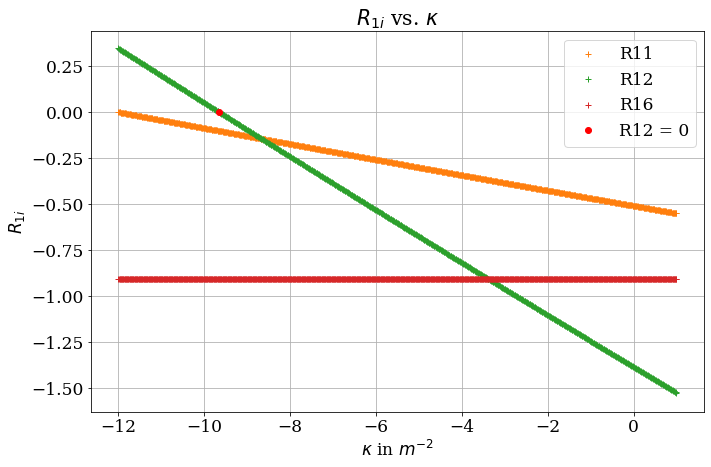

In [34]:
k = secant(reg, 0)

print("k =", k)

Quadrupole  = sp.Matrix([[sp.cos(sp.sqrt(k) * LQP),  sp.sin(sp.sqrt(k) * LQP) / sp.sqrt(k) , 0, 0, 0, 0],
                  [-sp.sqrt(k) * sp.sin(sp.sqrt(k) * LQP), sp.cos(sp.sqrt(k) * LQP),  0, 0, 0, 0],
                  [0, 0, sp.cosh(sp.sqrt(k) * LQP), sp.sinh(sp.sqrt(k) * LQP) / sp.sqrt(k), 0, 0],
                  [0, 0, sp.sqrt(k) *  sp.sinh(sp.sqrt(k) * LQP), sp.cosh(sp.sqrt(k) * LQP), 0, 0],
                  [0, 0, 0, 0, 1, LQP / gamma**2],
                  [0, 0, 0, 0, 0, 1]])

Matrix = matrixValues * DriftNullPlusEff * Quadrupole * DriftNull
uMatrix = umatrixValues  * DriftNullPlusEff * Quadrupole * DriftNull

print("Gefittet mit QP:")
display(sp.Matrix(Matrix))
print(f"det(M) = {Matrix.det()}")

plt.rcParams['figure.figsize'] = (11, 7)
  
plt.plot(kList, reg(kList, a0, a1))
plt.plot(kList, R11, "+", label = "R11")
plt.plot(kList, R12, "+", label = "R12")
plt.plot(kList, R16, "+", label = "R16")

plt.plot(k, 0, "ro", label = "R12 = 0")
plt.legend()
plt.xlabel("$\kappa$ in $m^{-2}$")
plt.ylabel("$R_{1i}$")
plt.title("$R_{1i}$ vs. $\kappa$")
plt.grid()
plt.savefig(f"Quadrupole.svg", format='svg', dpi=1000, bbox_inches='tight')

plt.show()



In [52]:
matrixValuesNonRounded = np.zeros(36).reshape(6,6)
umatrixValuesNonRounded = np.zeros(36).reshape(6,6)

for Column in range(6):
    for Row in range(6):
        R = float(np.array(Matrix)[Row][Column])
        uR = float(np.array(uMatrix)[Row][Column])
        
        matrixValuesNonRounded[Row][Column] = R
        umatrixValuesNonRounded[Row][Column] = uR

            
        matrixValues[Row][Column] = fnc.roundingDIN(R, uR, returnAsString=True)[0] #speichere diese Elemrente in matrixValues
        umatrixValues[Row][Column] = fnc.roundingDIN(R, uR, returnAsString=True)[1]

display(sp.Matrix(matrixValues))
display(sp.Matrix(umatrixValues))



Matrix([
[ -0.1013,    0.001,       0.0,       0.0, -0.000249,  -0.90646],
[ -2.6421,  -9.8412,       0.0,       0.0,       0.0,  -0.97835],
[     0.0,      0.0, -1.122759, -2.665173,       0.0,       0.0],
[     0.0,      0.0, -0.853576, -2.917044,       0.0,       0.0],
[ 2.29599,   8.9228,       0.0,       0.0,  0.999996, -0.030014],
[-0.00066, -0.00237,       0.0,       0.0,       0.0,  0.999766]])

Matrix([
[  0.001,   0.004,    0.0,    0.0, 1.5e-5,  8.0e-5],
[ 0.0008,  0.0028,    0.0,    0.0,    0.0, 0.00013],
[    0.0,     0.0, 5.0e-6, 1.6e-5,    0.0,     0.0],
[    0.0,     0.0, 7.0e-6, 2.1e-5,    0.0,     0.0],
[0.00027,  0.0009,    0.0,    0.0, 9.0e-6,  1.2e-5],
[0.00014, 0.00026,    0.0,    0.0,    0.0,  1.4e-5]])

In [57]:
R16 = matrixValuesNonRounded[0][5]
uR16 = umatrixValuesNonRounded[0][5]

wert = factor / abs(R16)
uwert = np.sqrt((R16**(-1) * ufactor)**2 + (- factor * R16**(-2) * uR16)**2)

wert, uwert

(1.0030416531121629, 0.009552052426464754)

# Bilder'

In [ ]:
sigma -0.5

In [ ]:
gaussianNumbers = np.random.normal(loc = 0, size = 100000)
plt.rcParams["figure.figsize"] = (10,6)
#count, bins, ignored = plt.hist(gaussianNumbers, bins = np.arange(-5, 5, 0.2), density=True, rwidth = 0.8, color ="lightgray")
# plt.hist returns 
    #count: wie viele Einträge pro bin
    #bins: Ränder der bins  [binBeginn:binEnde)
    #ignored: egal
sigma = np.std(gaussianNumbers)
mu = np.mean(gaussianNumbers)
bins = np.arange(-5, 5, 0.05)

gauss = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(bins-mu)**2 / (2 *sigma**2))

plt.plot(bins, gauss)

plt.axvline(x = sigma, ymax = 1, c = "red")
plt.axvline(x = -sigma, ymax = 1, c = "red", label = "Between red lines:\nWidth of the beam")

plt.axvline(x = 0, ymax = 1, c = "black")

plt.axhline(y = 0, c = "black", linewidth  = "0.3")

#plt.axhline(y = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(sigma-mu)**2 / (2 *sigma**2)), xmin = 0.5, xmax = sigma - 0.378, c = "green")

plt.plot((0, sigma), (1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(sigma-mu)**2 / (2 *sigma**2)), 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(sigma-mu)**2 / (2 *sigma**2))), c = 'green', linewidth = 3, label = "1 $\sigma$ interval")
plt.annotate("$\sigma$", (0.4, 0.25))

plt.ylabel("Electron density")
plt.xlabel("$x$ position in standard deviations")


plt.title("Electron denstiy of a particle bunch.")

plt.legend(loc = (0.65, 0.7))
plt.xlim(-4, 4)

plt.savefig(f"PhotonDensity.svg", format='svg', dpi=1000, bbox_inches='tight')
       
    
plt.show()
